# Active and/or Substantial Incubator History Visualizations

This notebook provides visualizations of Incubator edit data trends, for **active and/or substantial Incubator projects** that have not yet graduated.

Per [Wikimedia Incubator](https://incubator.wikimedia.org/wiki/Incubator:Wikis): test wikis are "**substantial**" if they have "at least 25 mainspace pages"; test wikis are "**active**" if they have had "some active content creation since the beginning of 2023". The latter has been interpreted to mean the test wiki had at least 1 new page created in the mainspace since the beginning of 2023.

Notebook components:

* **Part 1: Visualizing project size** (i.e. how many pages do these active and/or substantial Incubator projects have?)
* **Part 2: Visualizing first and last edits** (i.e., how long have these Incubator projects been in the Incubator?)
* **Part 3: Visualizing project size x start date** (i.e., looking at these projects' number of pages x how long they've been in the Incubator)
* **Part 4: Visualizing monthly edits** (i.e., for each of these projects, how many edits were made each month?)

In [ ]:
library(tidyverse)
library(plyr)
library(here)
library(matrixStats)
library(kableExtra)
library(pollster)
library(ggrepel)
library(jsonlite)
library(reticulate)
here()

# Load data

In [56]:
## Run all cells of notebook
#pycmd <- "python -m jupyter nbconvert --ExecutePreprocessor.timeout=None --to notebook --execute 02_wrangling_scripts/wrangle_final.ipynb"
#cat(pycmd)

## Execute command to run another notebook (in this case wrangle_final.ipynb)
## This will update the TSV outputs from that notebook, which will be loaded into this notebook in the cells below
#system(pycmd, intern = TRUE) #### update with names

In [57]:
#prep to be able to run spark queries using reticulate package
#per https://wikitech.wikimedia.org/wiki/Data_Engineering/Systems/Conda#wmfdata-python_through_reticulate
conda_env_data <- paste(
    system2(
        "conda",
        args = c("info", "-a", "--json"),
        stdout = TRUE),
    collapse = '') |>
    fromJSON()
use_condaenv(conda_env_data[['active_prefix']])
wmfdata <- import('wmfdata')


In [58]:
# Query page counts data
sql_text <- readLines(here("02_wrangling_scripts/queries/page_count_query.txt"))
sql_string <- paste(sql_text, collapse = "\n")
dfp_import <- wmfdata$spark$run(sql_string)

In [59]:
# Query first/last/percentile edits data
sql_text <- readLines(here("02_wrangling_scripts/queries/edit_percentiles_query.txt"))
sql_string <- paste(sql_text, collapse = "\n")
df_import <- wmfdata$spark$run(sql_string)

In [60]:
# Query monthly edits data
sql_text <- readLines(here("02_wrangling_scripts/queries/monthly_edits_query.txt"))
sql_string <- paste(sql_text, collapse = "\n")
dfe_import <- wmfdata$spark$run(sql_string)

In [61]:
# Query substantial test wikis in Incubator
sql_text <- readLines(here("02_wrangling_scripts/queries/substantial_query.txt"))
sql_string <- paste(sql_text, collapse = "\n")
substantial_import <- wmfdata$spark$run(sql_string)

In [62]:
# Query active test wikis in Incubator
sql_text <- readLines(here("02_wrangling_scripts/queries/active_query.txt"))
sql_string <- paste(sql_text, collapse = "\n")
active_import <- wmfdata$spark$run(sql_string)

In [77]:
# Join each df with language names and statuses, and FILTER OUT GRADS 
projs <- read_tsv(here("03_wrangled_data/projects.tsv"), show_col_types=F) %>%
 select(prefix, language_name, canonical_status, `test-host`, project)
df <- df_import %>% left_join(., projs, by="prefix") %>% filter(grepl("test", `test-host`))
dfp <- dfp_import %>% left_join(., projs, by="prefix") %>% filter(grepl("test", `test-host`))
dfe <- dfe_import %>% left_join(., projs, by="prefix") %>% filter(grepl("test", `test-host`))

In [78]:
# Merge substantial and active denotations with other imported dfs, and then
# filter for active and/or substantial only

df <- df %>% 
  full_join(., (substantial_import %>% select(prefix) %>% mutate(substantial="Yes")), by="prefix")%>% 
  full_join(., (active_import %>% select(prefix) %>% mutate(active="Yes")), by="prefix") %>%
  filter(active=="Yes"|substantial=="Yes") %>%
  filter(!is.na(total_edits)) # remove new wikis that don't have data in mediawiki_history yet

dfp <- dfp %>%
  full_join(., (substantial_import %>% select(prefix) %>% mutate(substantial="Yes")), by="prefix")%>% 
  full_join(., (active_import %>% select(prefix) %>% mutate(active="Yes")), by="prefix") %>%
  filter(active=="Yes"|substantial=="Yes")

dfe <- dfe %>%   full_join(., (substantial_import %>% select(prefix) %>% mutate(substantial="Yes")), by="prefix")%>% 
  full_join(., (active_import %>% select(prefix) %>% mutate(active="Yes")), by="prefix") %>%
  filter(active=="Yes"|substantial=="Yes")

# Part 1: Visualizing project size

In [65]:
# prep for project type
dfp$project_type <- NA
dfp$project_type[grepl("Wp/", dfp$prefix)] <- "Wikipedia"
dfp$project_type[grepl("Wb/", dfp$prefix)] <- "Wikibooks"
dfp$project_type[grepl("Wn/", dfp$prefix)] <- "Wikinews"
dfp$project_type[grepl("Wq/", dfp$prefix)] <- "Wikiquote"
dfp$project_type[grepl("Wt/", dfp$prefix)] <- "Wiktionary"
dfp$project_type[grepl("Wv/", dfp$prefix)] <- "Wikiversity"
dfp$project_type[grepl("Wy/", dfp$prefix)] <- "Wikivoyage"

In [66]:
dfp %>% 
 dplyr::group_by(project_type) %>% 
 dplyr::summarise(mean=round(mean(as.numeric(pages_count)),0)) %>% dplyr::ungroup() %>%
 left_join(., (dfp %>% dplyr::group_by(project_type) %>% dplyr::summarise(median=median(as.numeric(pages_count))) %>% dplyr::ungroup()), by="project_type") %>%
 dplyr::rename("mean pages" = "mean", "median pages" = "median") %>% select(1,3,2)

project_type median pages mean pages
1 Wikibooks     30.0        104       
2 Wikinews     108.5        391       
3 Wikipedia       NA         NA       
4 Wikiquote       NA         NA       
5 Wikivoyage    87.5        247       
6 Wiktionary      NA         NA

Warning message:
“Removed 9 rows containing missing values or values outside the scale range
(`geom_bar()`).”


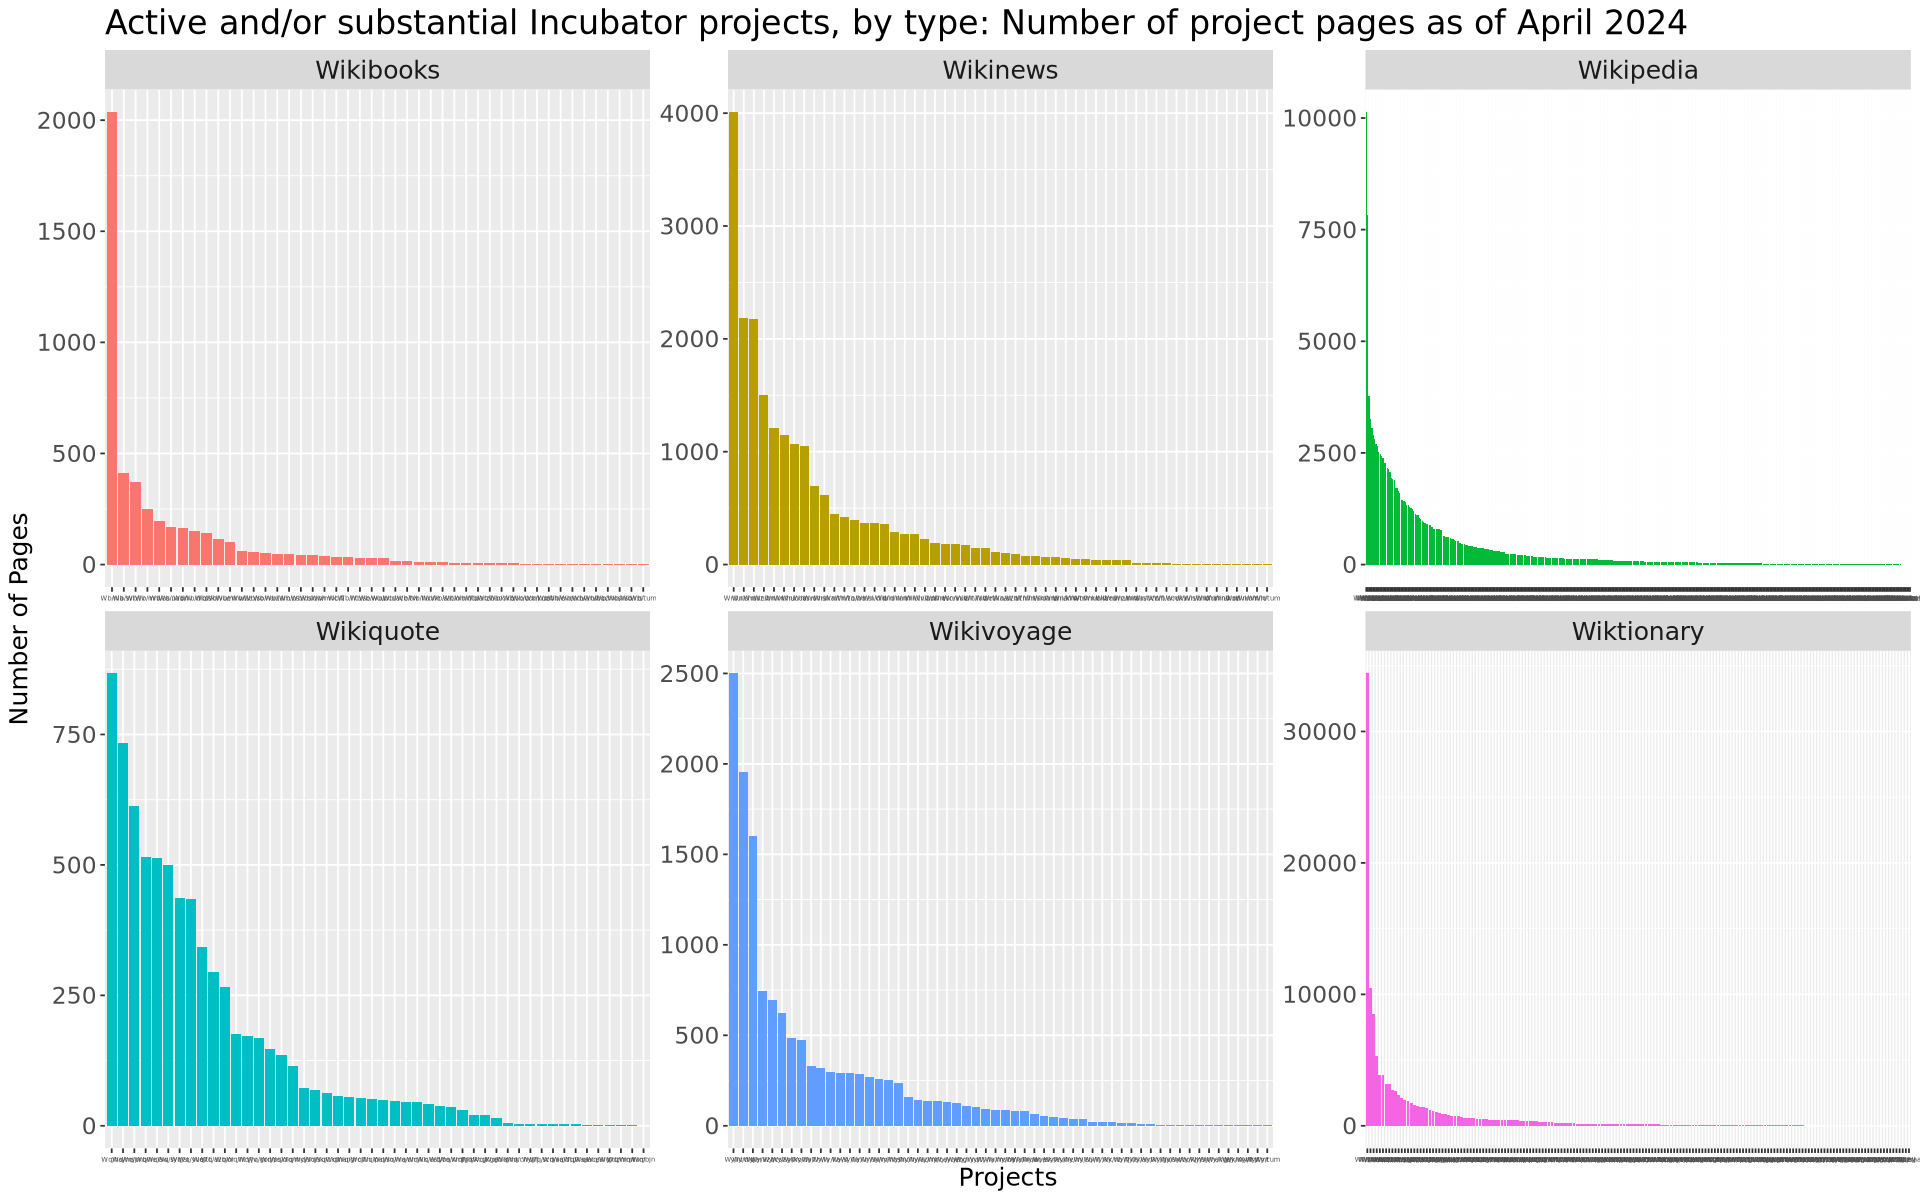

In [67]:
options(repr.plot.width=16, repr.plot.height=10)
dfp %>%
 ggplot(aes(x=reorder(prefix,-pages_count), y=pages_count, fill=project_type)) +
 geom_bar(stat="identity") +
 facet_wrap(.~project_type, ncol=3, scales="free") +
 theme(plot.title=element_text(size=20), 
       axis.text.y=element_text(size=14),
       axis.text.x=element_text(size=04),
       axis.title=element_text(size=15),
       strip.text=element_text(size=15),
       legend.position="none") +
 labs(title="Active and/or substantial Incubator projects, by type: Number of project pages as of April 2024") +
 xlab("Projects") +
 ylab("Number of Pages")

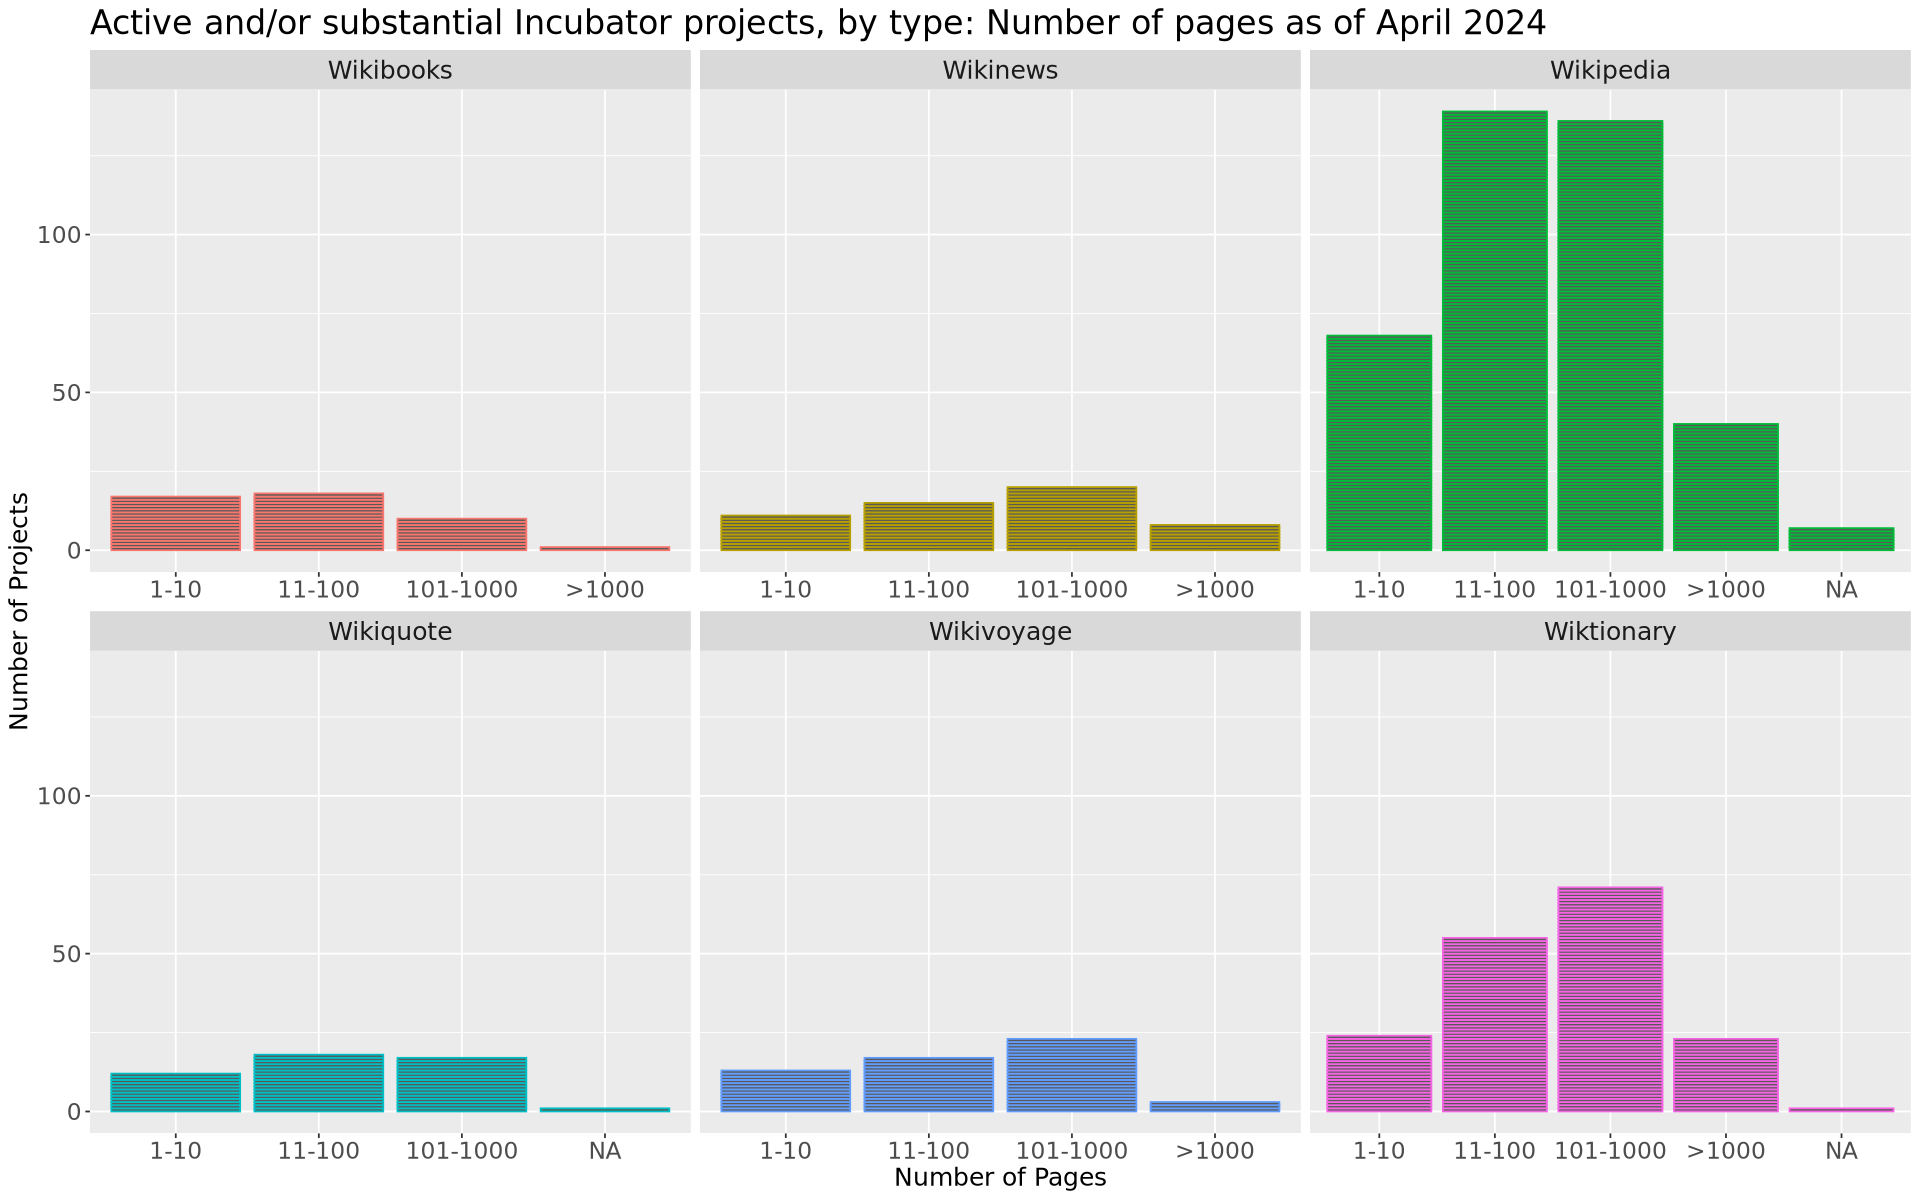

In [68]:
# BUCKETS
dfp$bucket <- NA
dfp$bucket[dfp$pages_count>=1 & dfp$pages_count==0] <- "0"
dfp$bucket[dfp$pages_count>=1 & dfp$pages_count<11] <- "1-10"
dfp$bucket[dfp$pages_count>10 & dfp$pages_count<101] <- "11-100"
dfp$bucket[dfp$pages_count>100 & dfp$pages_count<1001] <- "101-1000"
dfp$bucket[dfp$pages_count>1000] <- ">1000"
dfp$bucket <-  factor(dfp$bucket, levels = c("0", "1-10", "11-100", "101-1000", ">1000"))

#dummy count
dfp$dummy_count <- 1

#plot
dfp %>%
 ggplot(aes(x=reorder(bucket,-dummy_count), y=dummy_count, color=project_type)) +
 geom_bar(stat="identity") + xlab("Number of Pages") +
 theme(plot.title=element_text(size=20), 
       axis.text=element_text(size=14),
       axis.title=element_text(size=15),
       strip.text=element_text(size=15),
       legend.position="none") +
 ylab("Number of Projects") +
 labs(title="Active and/or substantial Incubator projects, by type: Number of pages as of April 2024") +
 facet_wrap(.~project_type, ncol=3, scales="free_x")

In [69]:
# Show data plotted above as a table (i.e., page number buckets project, but as %s)
dfp$weight=1
as.data.frame(moe_crosstab(df=dfp, x=project_type, y=bucket, weight=weight)) %>%
 mutate(pct=paste0(round(pct,1), "%")) %>%
 select(project_type, bucket, pct) %>%
 spread(key=bucket, value=pct)

project_type 1-10  11-100 101-1000 >1000
1 Wikibooks    37%   39.1%  21.7%    2.2% 
2 Wikinews     20.4% 27.8%  37%      14.8%
3 Wikipedia    17.8% 36.3%  35.5%    10.4%
4 Wikiquote    25.5% 38.3%  36.2%    NA   
5 Wikivoyage   23.2% 30.4%  41.1%    5.4% 
6 Wiktionary   13.9% 31.8%  41%      13.3%

In [70]:
# Which projects have > 5,000 pages????
dfp %>% filter(pages_count > 5000)

snapshot prefix pages_count language_name   canonical_status test-host
1 2024-05  Wt/mnc  8487       Manchu          NA               test     
2 2024-05  Wt/wuu 34417       Wu              NA               test     
3 2024-05  Wp/khw 10131       Khowar          NA               test     
4 2024-05  Wt/mad  5333       Madurese        NA               test     
5 2024-05  Wt/war 10480       Waray           NA               test     
6 2024-05  Wp/bgn  7817       Western Baluchi NA               test     
  project    substantial active project_type bucket dummy_count weight
1 Wiktionary Yes         Yes    Wiktionary   >1000  1           1     
2 Wiktionary Yes         NA     Wiktionary   >1000  1           1     
3 Wikipedia  Yes         Yes    Wikipedia    >1000  1           1     
4 Wiktionary Yes         Yes    Wiktionary   >1000  1           1     
5 Wiktionary Yes         Yes    Wiktionary   >1000  1           1     
6 Wikipedia  Yes         Yes    Wikipedia    >1000  1           1

In [71]:
# How many projects have between 1 and 5 pages????
nrow(dfp %>% filter(pages_count < 6))

[1] 101

# Part 2: Visualizing first and last edits

In [79]:
# prep for project type
df$project_type <- NA
df$project_type[grepl("Wp/", df$prefix)] <- "Wikipedia"
df$project_type[grepl("Wb/", df$prefix)] <- "Wikibooks"
df$project_type[grepl("Wn/", df$prefix)] <- "Wikinews"
df$project_type[grepl("Wq/", df$prefix)] <- "Wikiquote"
df$project_type[grepl("Wt/", df$prefix)] <- "Wiktionary"
df$project_type[grepl("Wv/", df$prefix)] <- "Wikiversity"
df$project_type[grepl("Wy/", df$prefix)] <- "Wikivoyage"

In [80]:
# Define total days in Incubator
df <- df %>% 
 mutate(total_days_in_incubator = Sys.Date() - as.Date(first_edit_timestamp)) %>%
 mutate(total_days_in_incubator = as.numeric(gsub(" days", "", total_days_in_incubator))) %>%
 mutate(total_days_since_last_edit = Sys.Date() - as.Date(last_edit_timestamp)) %>%
 mutate(total_days_since_last_edit = as.numeric(gsub(" days", "", total_days_since_last_edit))) 
head(df)

prefix total_edits first_edit_timestamp last_edit_timestamp
1 Wb/rjs    3        2023-12-22           2024-02-25         
2 Wt/gld  370        2020-07-14           2023-03-29         
3 Wn/nia  251        2021-01-14           2024-05-03         
4 Wp/hoc  478        2016-10-03           2024-06-01         
5 Wt/ksh 1881        2013-09-03           2022-09-28         
6 Wt/mag   40        2023-12-31           2024-05-06         
  avg_first_edit_5pct avg_last_edit_5pct language_name canonical_status
1 2023-12-22          2024-02-25         Rajbanshi     NA              
2 2020-10-27          2022-10-12         Nanai         NA              
3 2021-01-14          2023-11-26         Nias          NA              
4 2016-10-03          2024-05-21         Ho            NA              
5 2013-09-03          2014-09-12         Colognian     NA              
6 2023-12-31          2024-05-06         Magahi        NA              
  test-host project    substantial active project_type total_days_in_incubator
1 test      Wikibooks  NA          Yes    Wikibooks     189                   
2 test      Wiktionary Yes         Yes    Wiktionary   1445                   
3 test      Wikinews   NA          Yes    Wikinews     1261                   
4 test      Wikipedia  Yes         Yes    Wikipedia    2825                   
5 test      Wiktionary Yes         NA     Wiktionary   3951                   
6 test      Wiktionary NA          Yes    Wiktionary    180                   
  total_days_since_last_edit
1 124                       
2 457                       
3  56                       
4  27                       
5 639                       
6  53

## How long have active and/or substantial Incubator projects been in the Incubator?

In [81]:
# Min and max of all active and/or substantial Incubator projects
print(min(df$total_days_in_incubator))
print(max(df$total_days_in_incubator))

[1] 29
[1] 7869


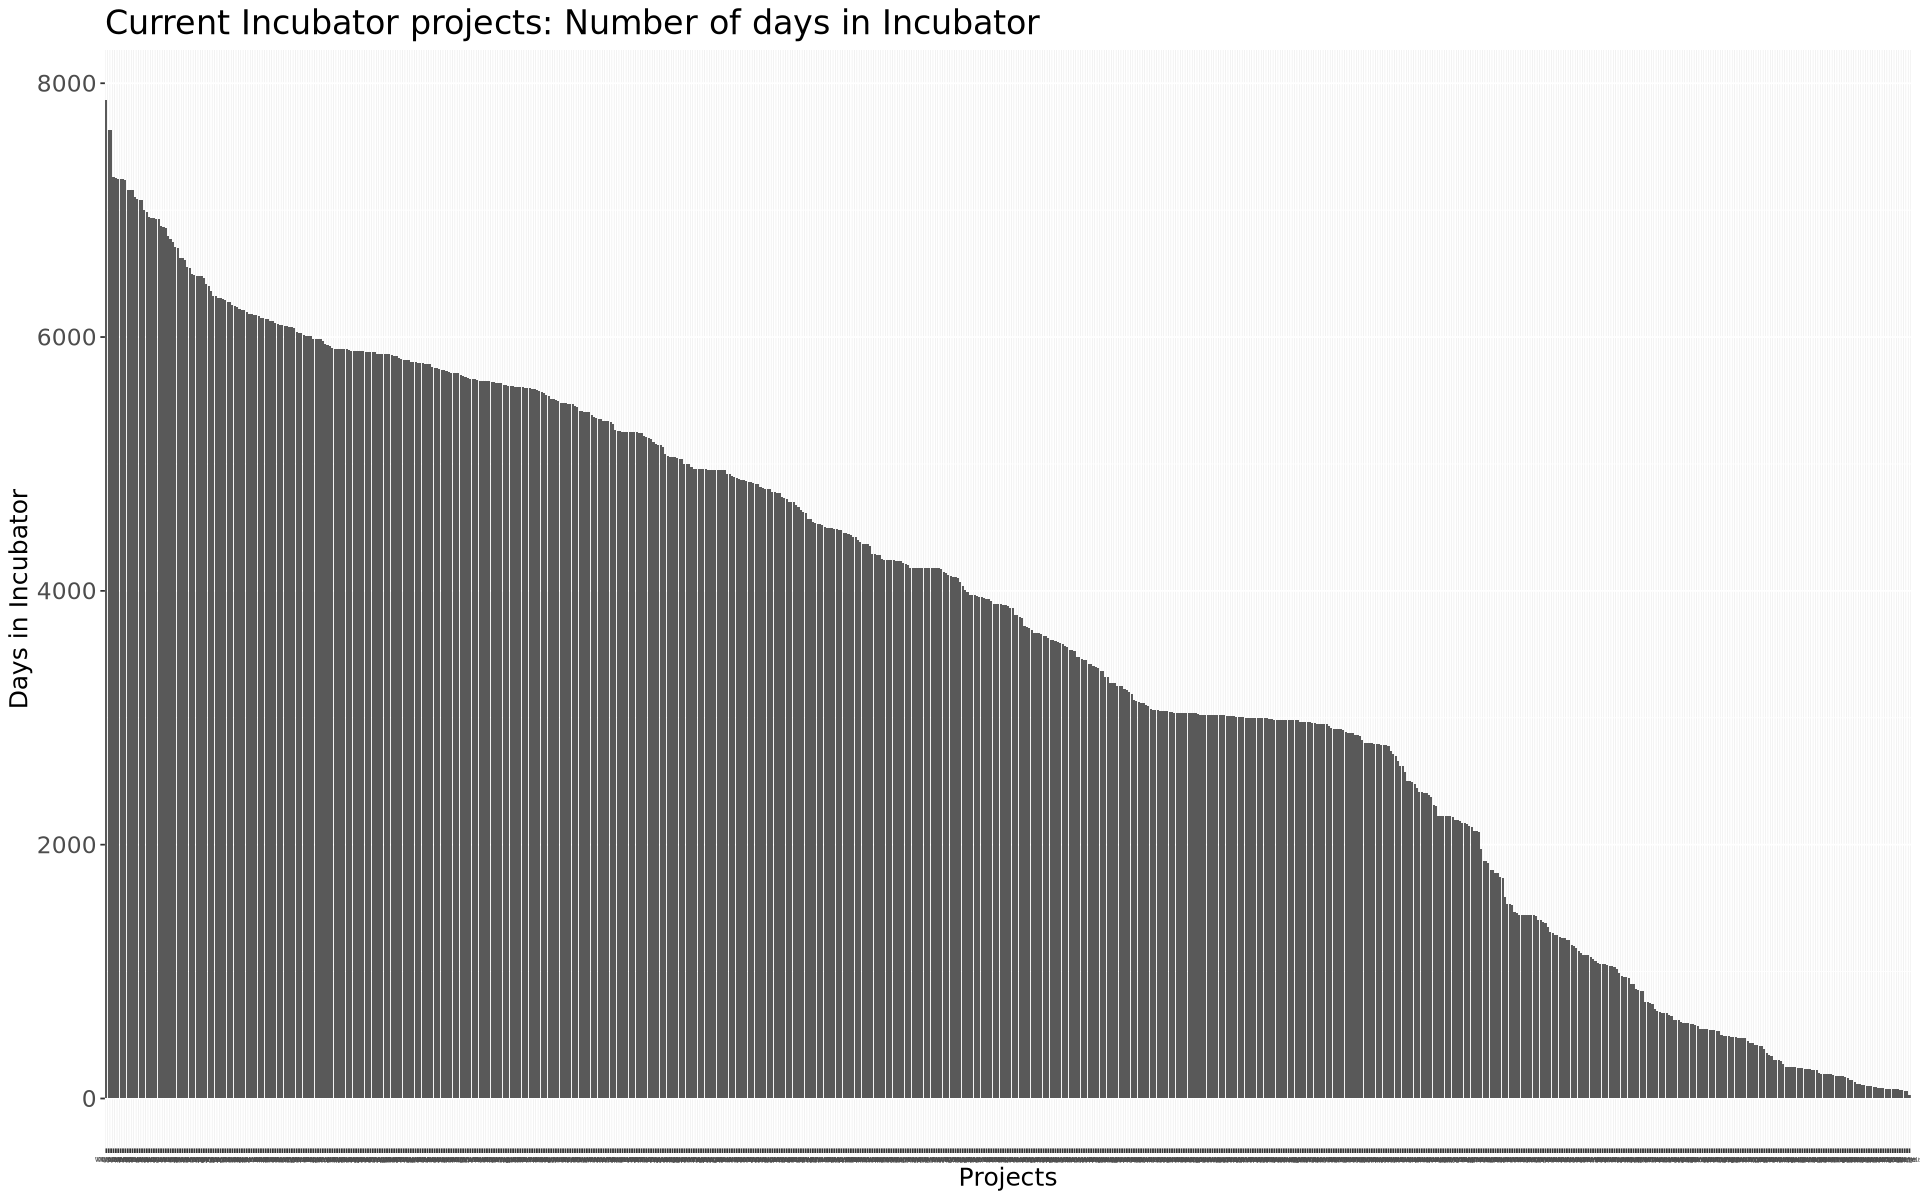

In [82]:
# Range of all active and/or substantial Incubator projects
options(repr.plot.width=16, repr.plot.height=10)
df %>%
 ggplot(aes(x=reorder(prefix,-total_days_in_incubator), y=total_days_in_incubator)) +
 geom_bar(stat="identity") + xlab("Projects") +
theme(plot.title=element_text(size=20), 
       axis.text.y=element_text(size=14),
       axis.text.x=element_text(size=04),
       axis.title=element_text(size=15),
       legend.position="none") +
 ylab("Days in Incubator") +
 labs(title="Current Incubator projects: Number of days in Incubator")

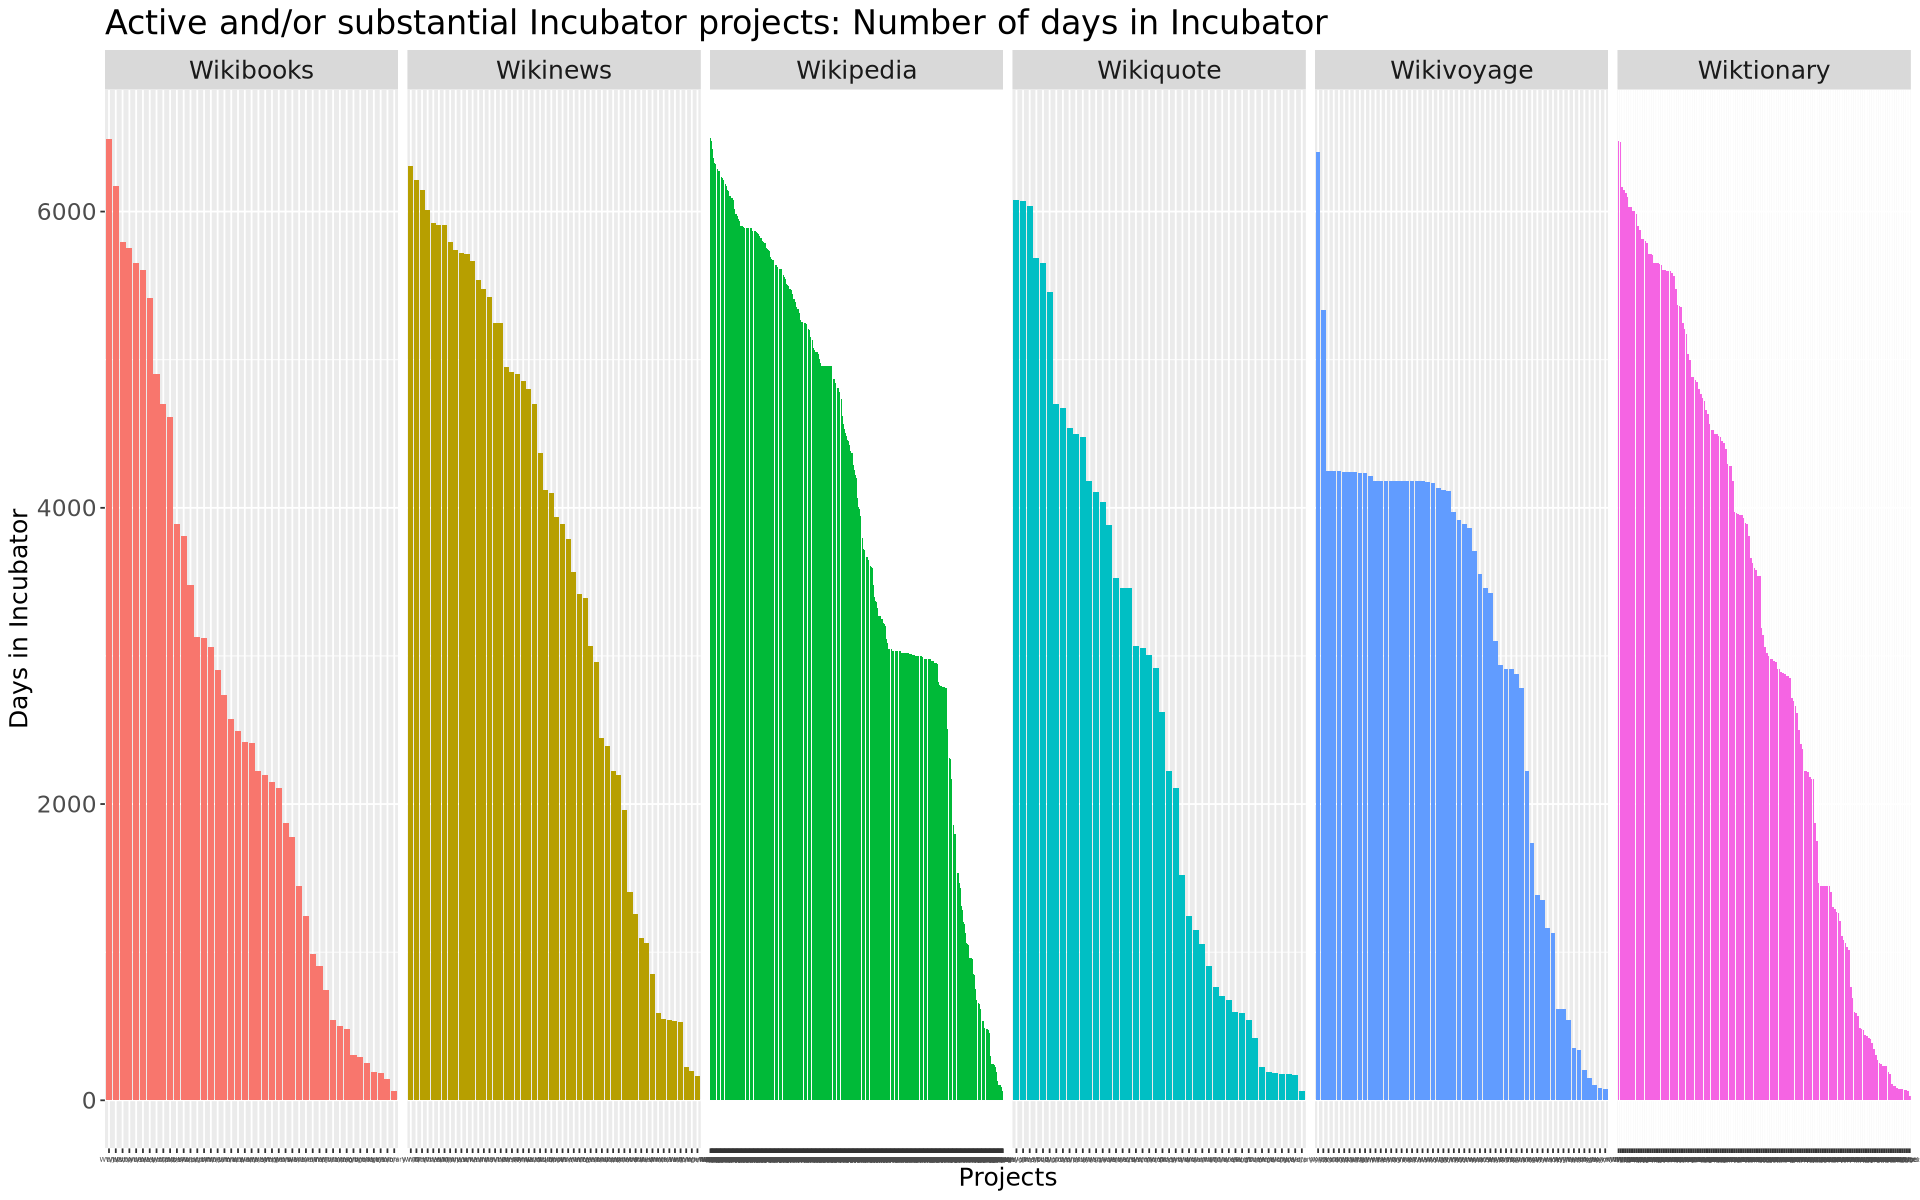

In [83]:
# Range of all active and/or substantial Incubator projects, by project type
df %>%
 filter(total_days_in_incubator < 6525) %>%
 ggplot(aes(x=reorder(prefix,-total_days_in_incubator), y=total_days_in_incubator, fill=project_type)) +
 geom_bar(stat="identity") +
 ylab("Days in Incubator") + xlab("Projects") +
 labs(title="Active and/or substantial Incubator projects: Number of days in Incubator") +
 facet_grid(.~project_type, scales="free_x") + 
 theme(plot.title=element_text(size=20), 
       axis.text.y=element_text(size=14),
       axis.text.x=element_text(size=04),
       axis.title=element_text(size=15),
       strip.text=element_text(size=15),
       legend.position="none") 

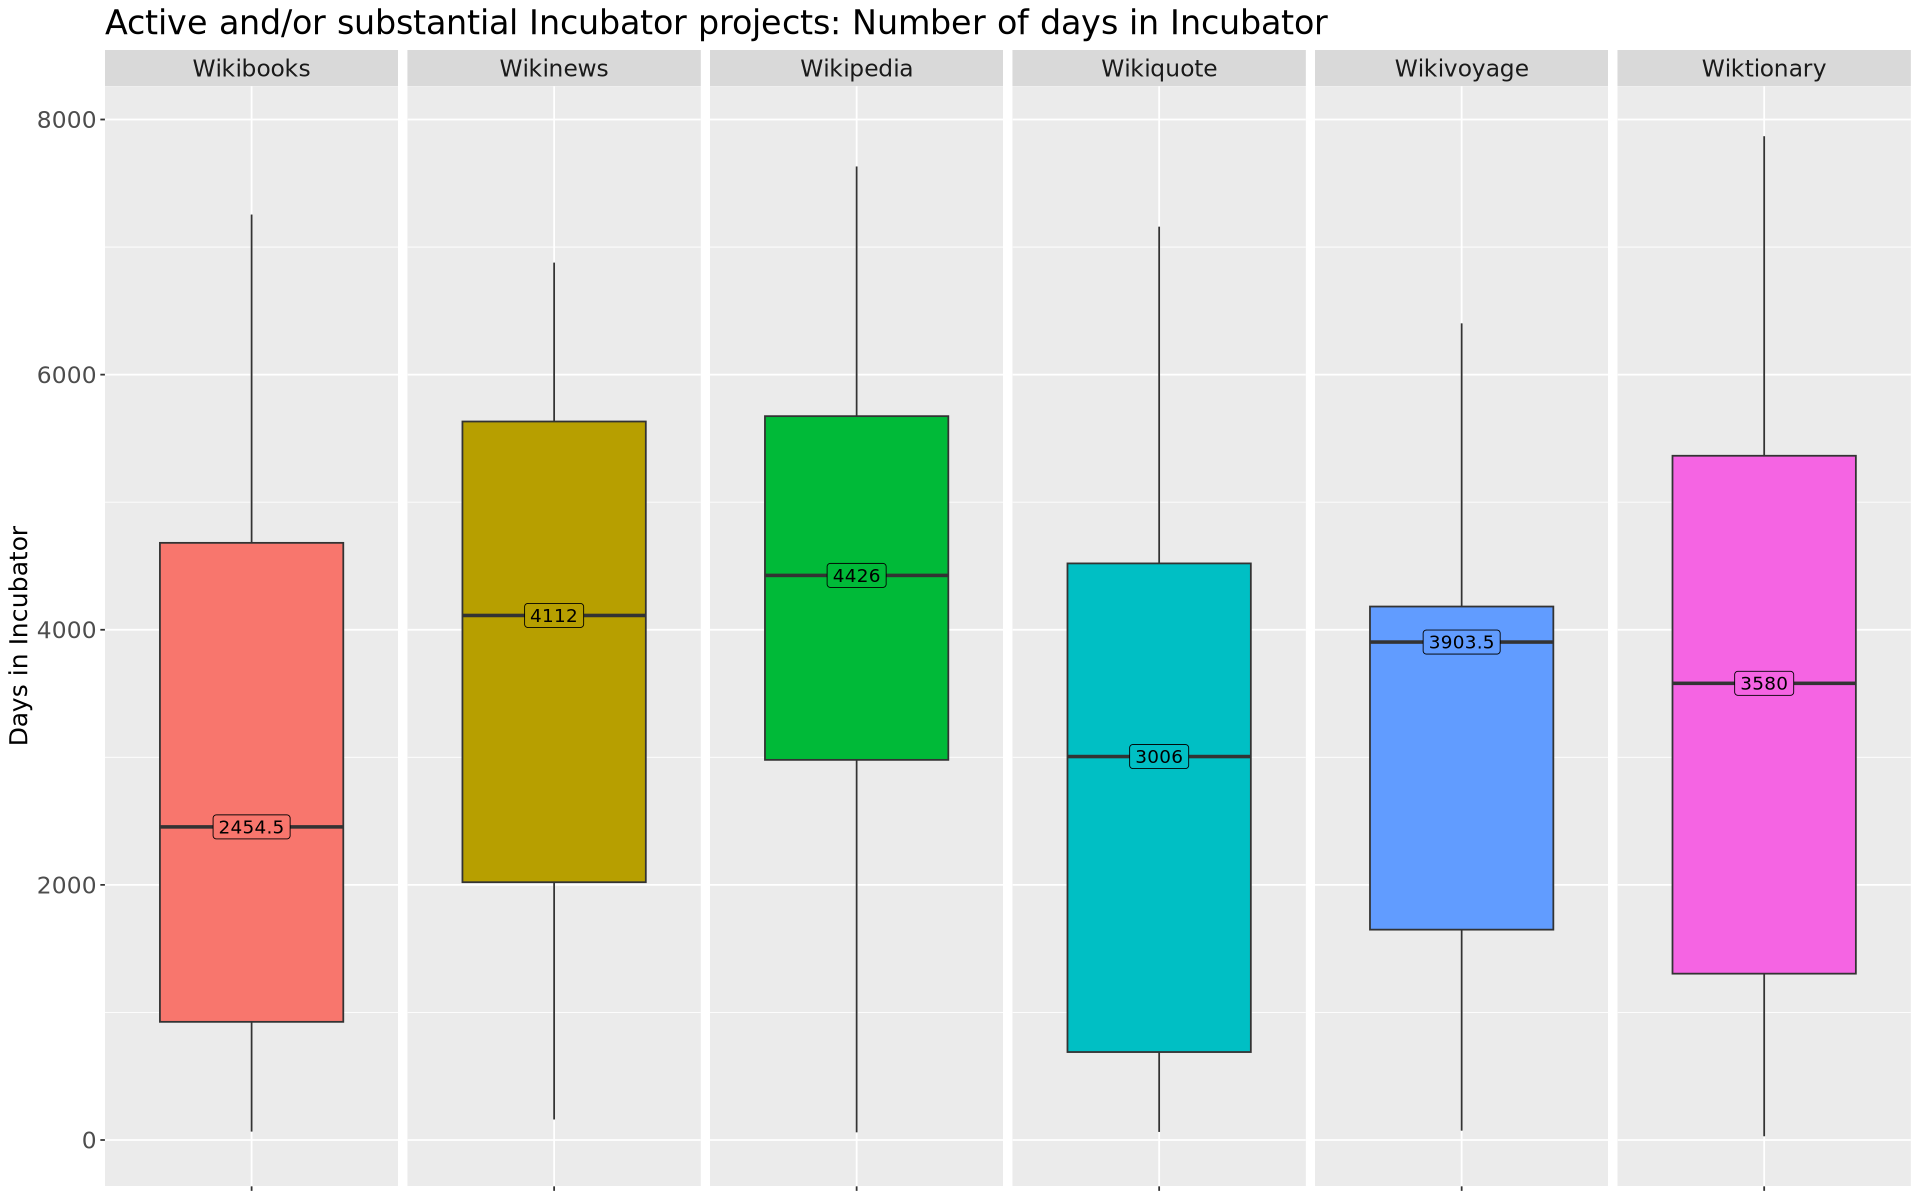

In [84]:
# Boxplots of all active and/or substantial Incubator projects, by project type

# first summary stats
summ <- df %>% 
  dplyr::group_by(project_type) %>% 
  dplyr::summarize(mean = mean(total_days_in_incubator), median = median(total_days_in_incubator), sd = sd(total_days_in_incubator)) %>%
  dplyr::ungroup()

# now plot
df %>%
 ggplot(aes(x = project_type, y = total_days_in_incubator, fill = project_type)) +
 geom_boxplot() +
 facet_grid(.~project_type, scales="free_x") + 
 geom_label(data = summ, aes(x = project_type, y = median, label = median)) +
 theme(legend.position="none", 
       strip.text=element_text(size=14), plot.title=element_text(size=20),
       axis.text.y=element_text(size=14), axis.title.y=element_text(size=15),
       axis.text.x = element_blank(), axis.title.x = element_blank()) +
 ylab("Days in Incubator") +
 labs(title="Active and/or substantial Incubator projects: Number of days in Incubator") 

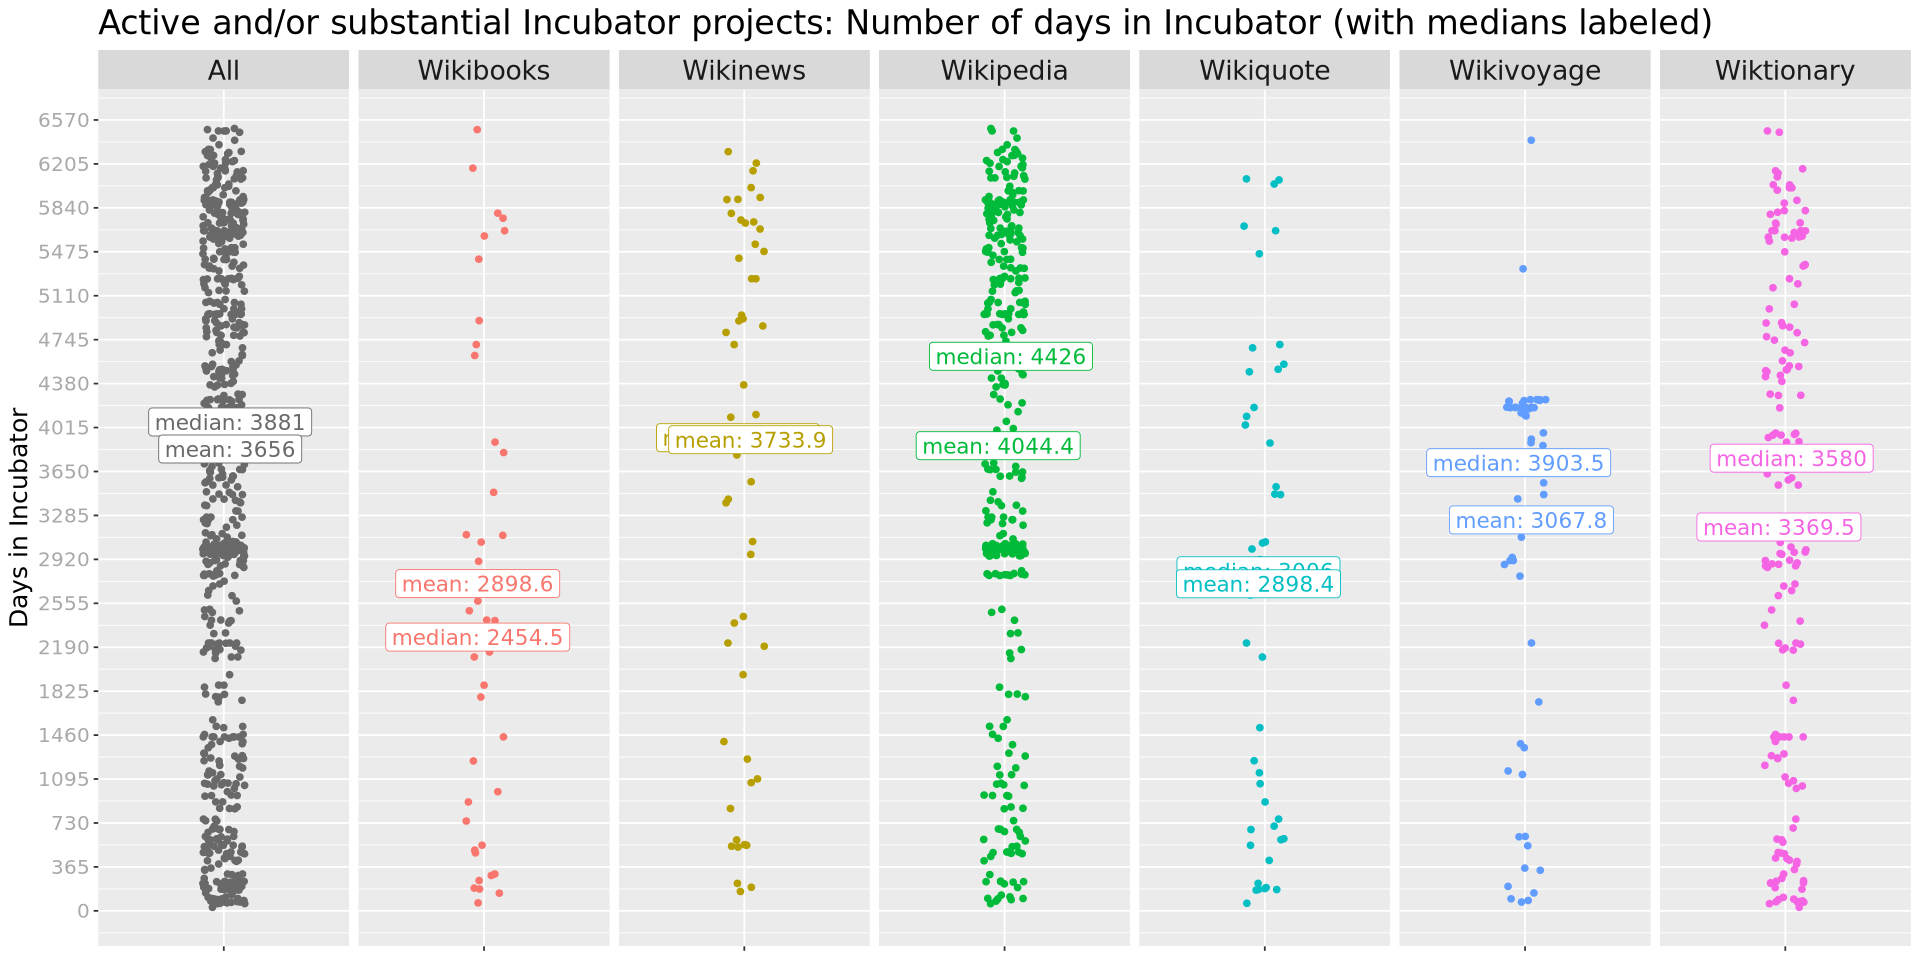

In [85]:
# Dot plots of all active and/or substantial Incubator projects, by project type

options(repr.plot.width=16, repr.plot.height=08)

# First, add an "All" project type category
df_all <- df
df_all$project_type <- "All"
df_all <- rbind(df, df_all)

# Then, summary stats
summ <- df_all %>% 
  dplyr::group_by(project_type) %>% 
  dplyr::summarize(mean = mean(total_days_in_incubator), median = median(total_days_in_incubator), sd = sd(total_days_in_incubator)) %>%
  dplyr::ungroup()

# Now plot
df_all %>%
 filter(total_days_in_incubator < 6525) %>% # days starting June 2006
 ggplot(aes(x = project_type, y = total_days_in_incubator, color = project_type)) +
# geom_violin() +
 geom_point(position = position_jitter(seed = 1, width = 0.1)) +
 facet_grid(.~project_type, scales="free_x") + 
 geom_label_repel(  min.segment.length = 2,
      data = summ, aes(x = project_type, y = median, label = paste0("median: ", median), size=20)) +
 geom_label_repel( min.segment.length = 1,
     data = summ, aes(x = project_type, y = mean, label = paste0("mean: ", round(mean,1)), size=20)) + 
 theme(legend.position="none", strip.text=element_text(size=16), plot.title = element_text(size=20),
       plot.caption = element_text(size=12), axis.text.x = element_blank(), axis.title.x = element_blank(), 
       axis.title.y = element_text(size=15), axis.text.y = element_text(size=12, color="dark grey")) +
 scale_y_continuous(name="Days in Incubator", breaks=seq(0,6600,365)) +
 scale_color_manual(values = c("dimgray", "#f8766dff", "#b79f00ff", "#00ba39ff", "#03bfc4ff", "#619cffff", "#f564e3ff")) +
 labs(title = "Active and/or substantial Incubator projects: Number of days in Incubator (with medians labeled)")

In [86]:
## How many projects have been in the Incubator for more than 4 years (1460 days)?

nrow(df %>% filter(total_days_in_incubator>1460) %>% arrange(desc(total_days_in_incubator)))

[1] 594

In [87]:
## Which projects have been in the Inubator for more than 4 years (1460 days)?
## remove "head()" for full list
head( df %>% filter(total_days_in_incubator>1460) %>% arrange(desc(total_days_in_incubator)) )

prefix total_edits first_edit_timestamp last_edit_timestamp
1 Wt/sco  8291       2002-12-12           2024-01-30         
2 Wp/vmf  6933       2003-08-06           2024-05-26         
3 Wp/na  60977       2003-08-09           2024-05-14         
4 Wt/zea  9930       2004-08-08           2024-05-31         
5 Wb/lv    609       2004-08-17           2024-02-27         
6 Wp/mh    989       2004-08-29           2024-03-10         
  avg_first_edit_5pct avg_last_edit_5pct language_name         
1 2004-09-19          2019-10-21         Scots                 
2 2005-08-22          2023-01-02         East Franconian German
3 2005-09-06          2022-04-24         Nauru                 
4 2007-12-31          2024-02-10         Zeelandic             
5 2006-08-10          2016-12-20         Latvian               
6 2005-12-04          2023-07-23         Marshallese           
  canonical_status test-host     project    substantial active project_type
1 NA               test          Wiktionary Yes         Yes    Wiktionary  
2 NA               test          Wikipedia  Yes         Yes    Wikipedia   
3 closed           test (closed) Wikipedia  Yes         Yes    Wikipedia   
4 NA               test          Wiktionary Yes         Yes    Wiktionary  
5 closed           test (closed) Wikibooks  Yes         NA     Wikibooks   
6 closed           test (closed) Wikipedia  Yes         Yes    Wikipedia   
  total_days_in_incubator total_days_since_last_edit
1 7869                    150                       
2 7632                     33                       
3 7629                     45                       
4 7264                     28                       
5 7255                    122                       
6 7243                    110

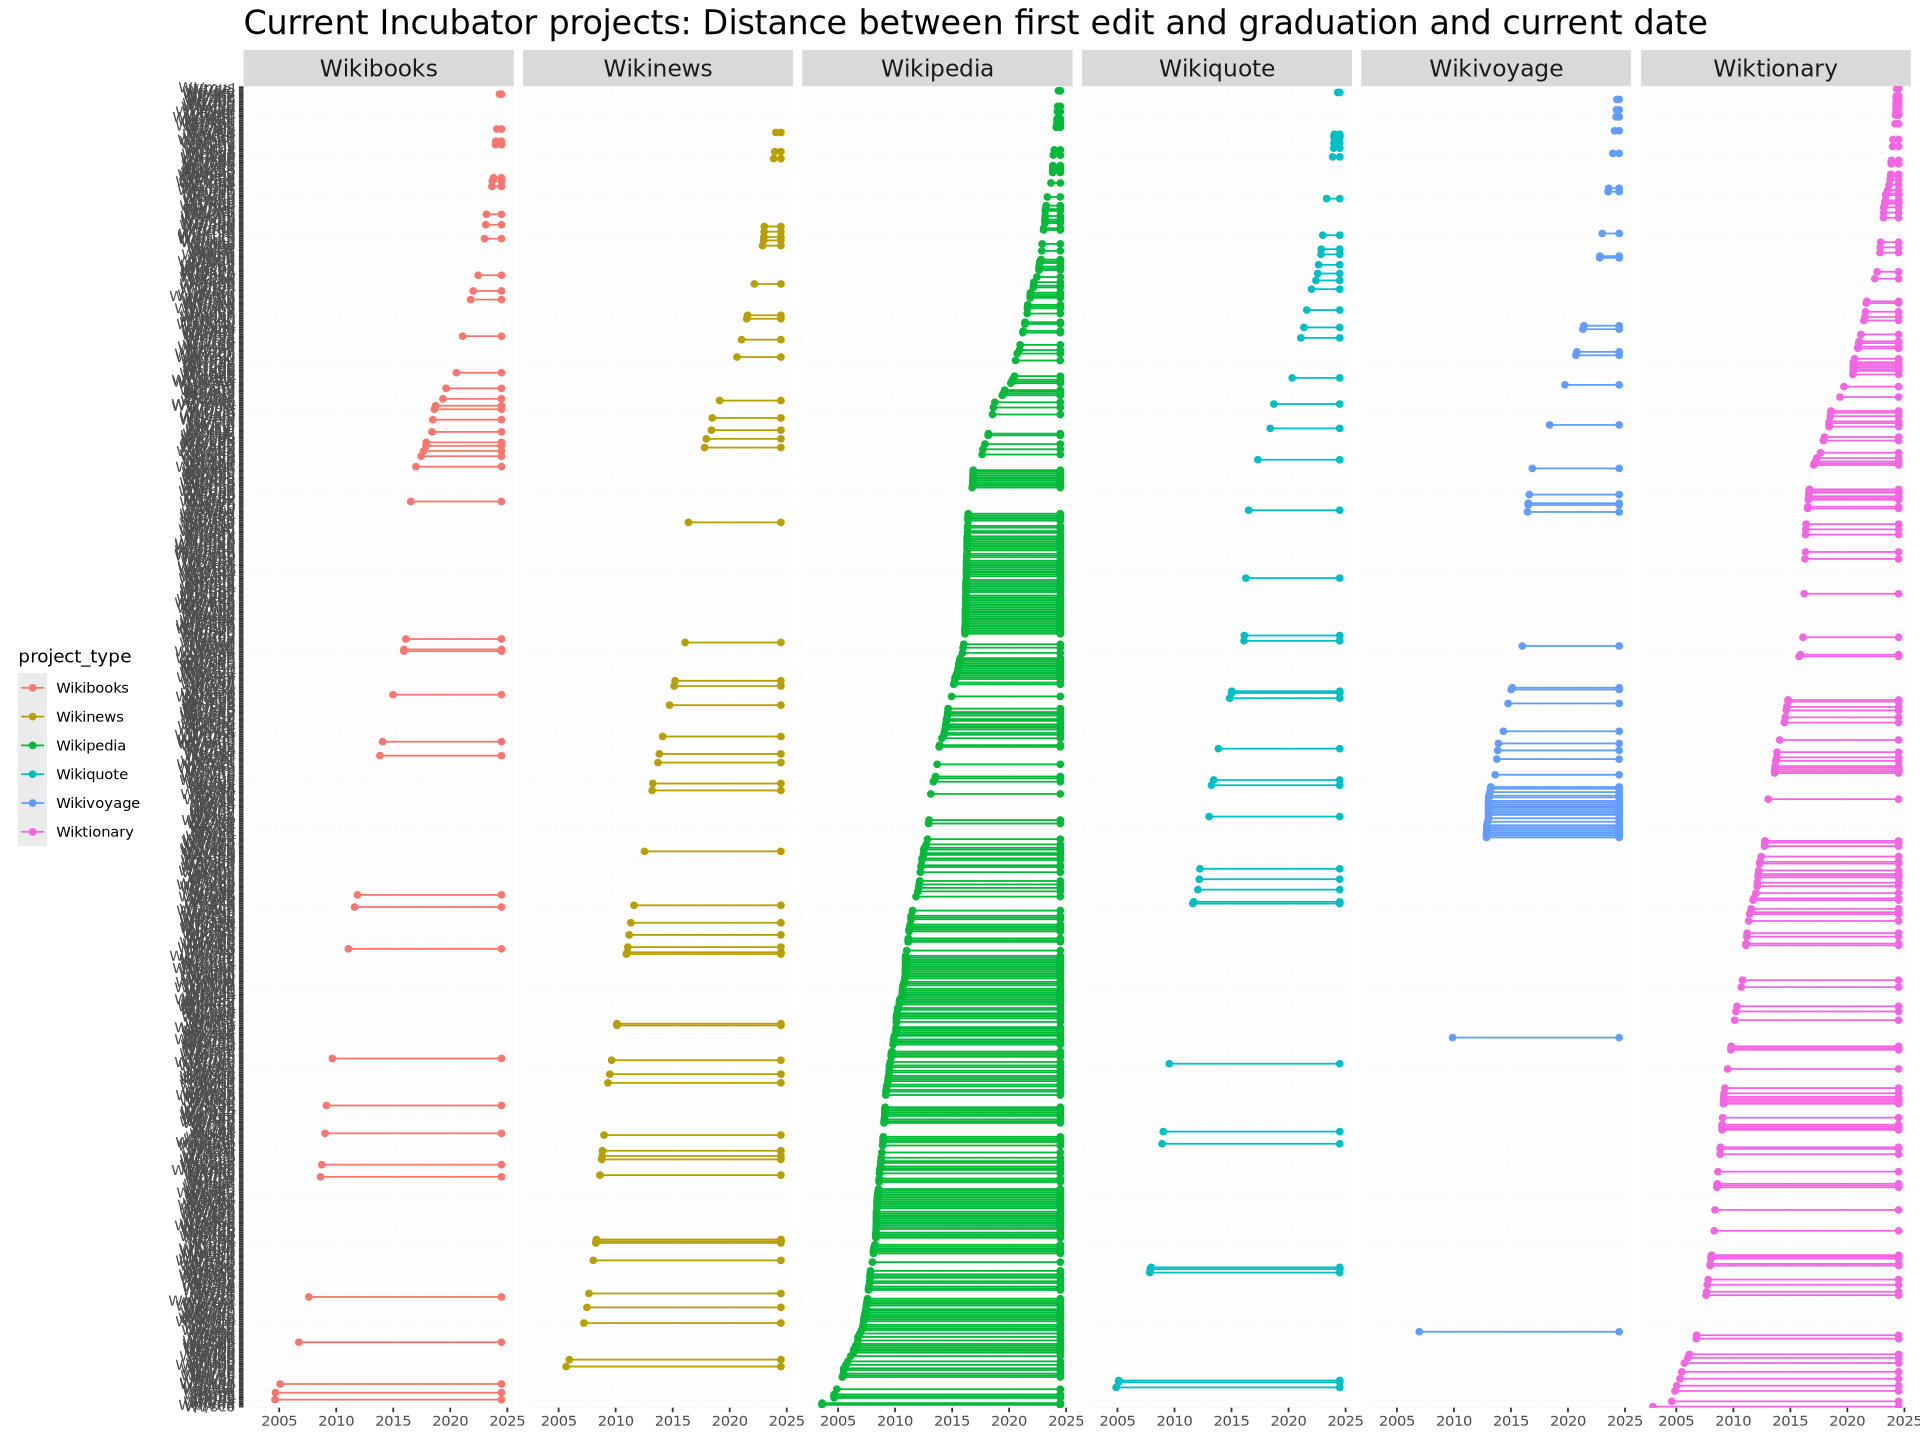

In [91]:
# Plot time in incubator
options(repr.plot.width=16, repr.plot.height=12)

## PREP

first_edit <- df %>% 
  select(prefix, language_name, first_edit_timestamp, project_type, total_days_since_last_edit) %>%
  mutate(first_edit_timestamp = as.Date(first_edit_timestamp)) %>%
  mutate(type= "1- First edit") %>%
  dplyr::rename(edit = first_edit_timestamp)          
current <- df %>% 
  mutate(current_dt = as.Date(Sys.Date())) %>%
  select(prefix, language_name, current_dt, project_type, total_days_since_last_edit) %>%
  mutate(type= "3- Current date") %>%
  dplyr::rename(edit = current_dt)

first_to_current <- rbind(first_edit, current) ## bind

first_to_current <- df %>%
  select(prefix, first_edit_timestamp) %>%
  right_join(., first_to_current, by = "prefix") ## re-add first_edit_timestamp column for ordering in plot


## PLOT
first_to_current %>%
  ggplot(aes(x=reorder(prefix,edit), y=edit, color=project_type)) +
  geom_line() +
  geom_point() +
  coord_flip() +
  facet_grid(.~project_type) +
  theme(legend.position = "left",  strip.text=element_text(size=14), axis.title = element_blank(),
       plot.title = element_text(size=20)) +
 labs(title = "Current Incubator projects: Distance between first edit and graduation and current date")


# Part 3: Visualizing project size x start date

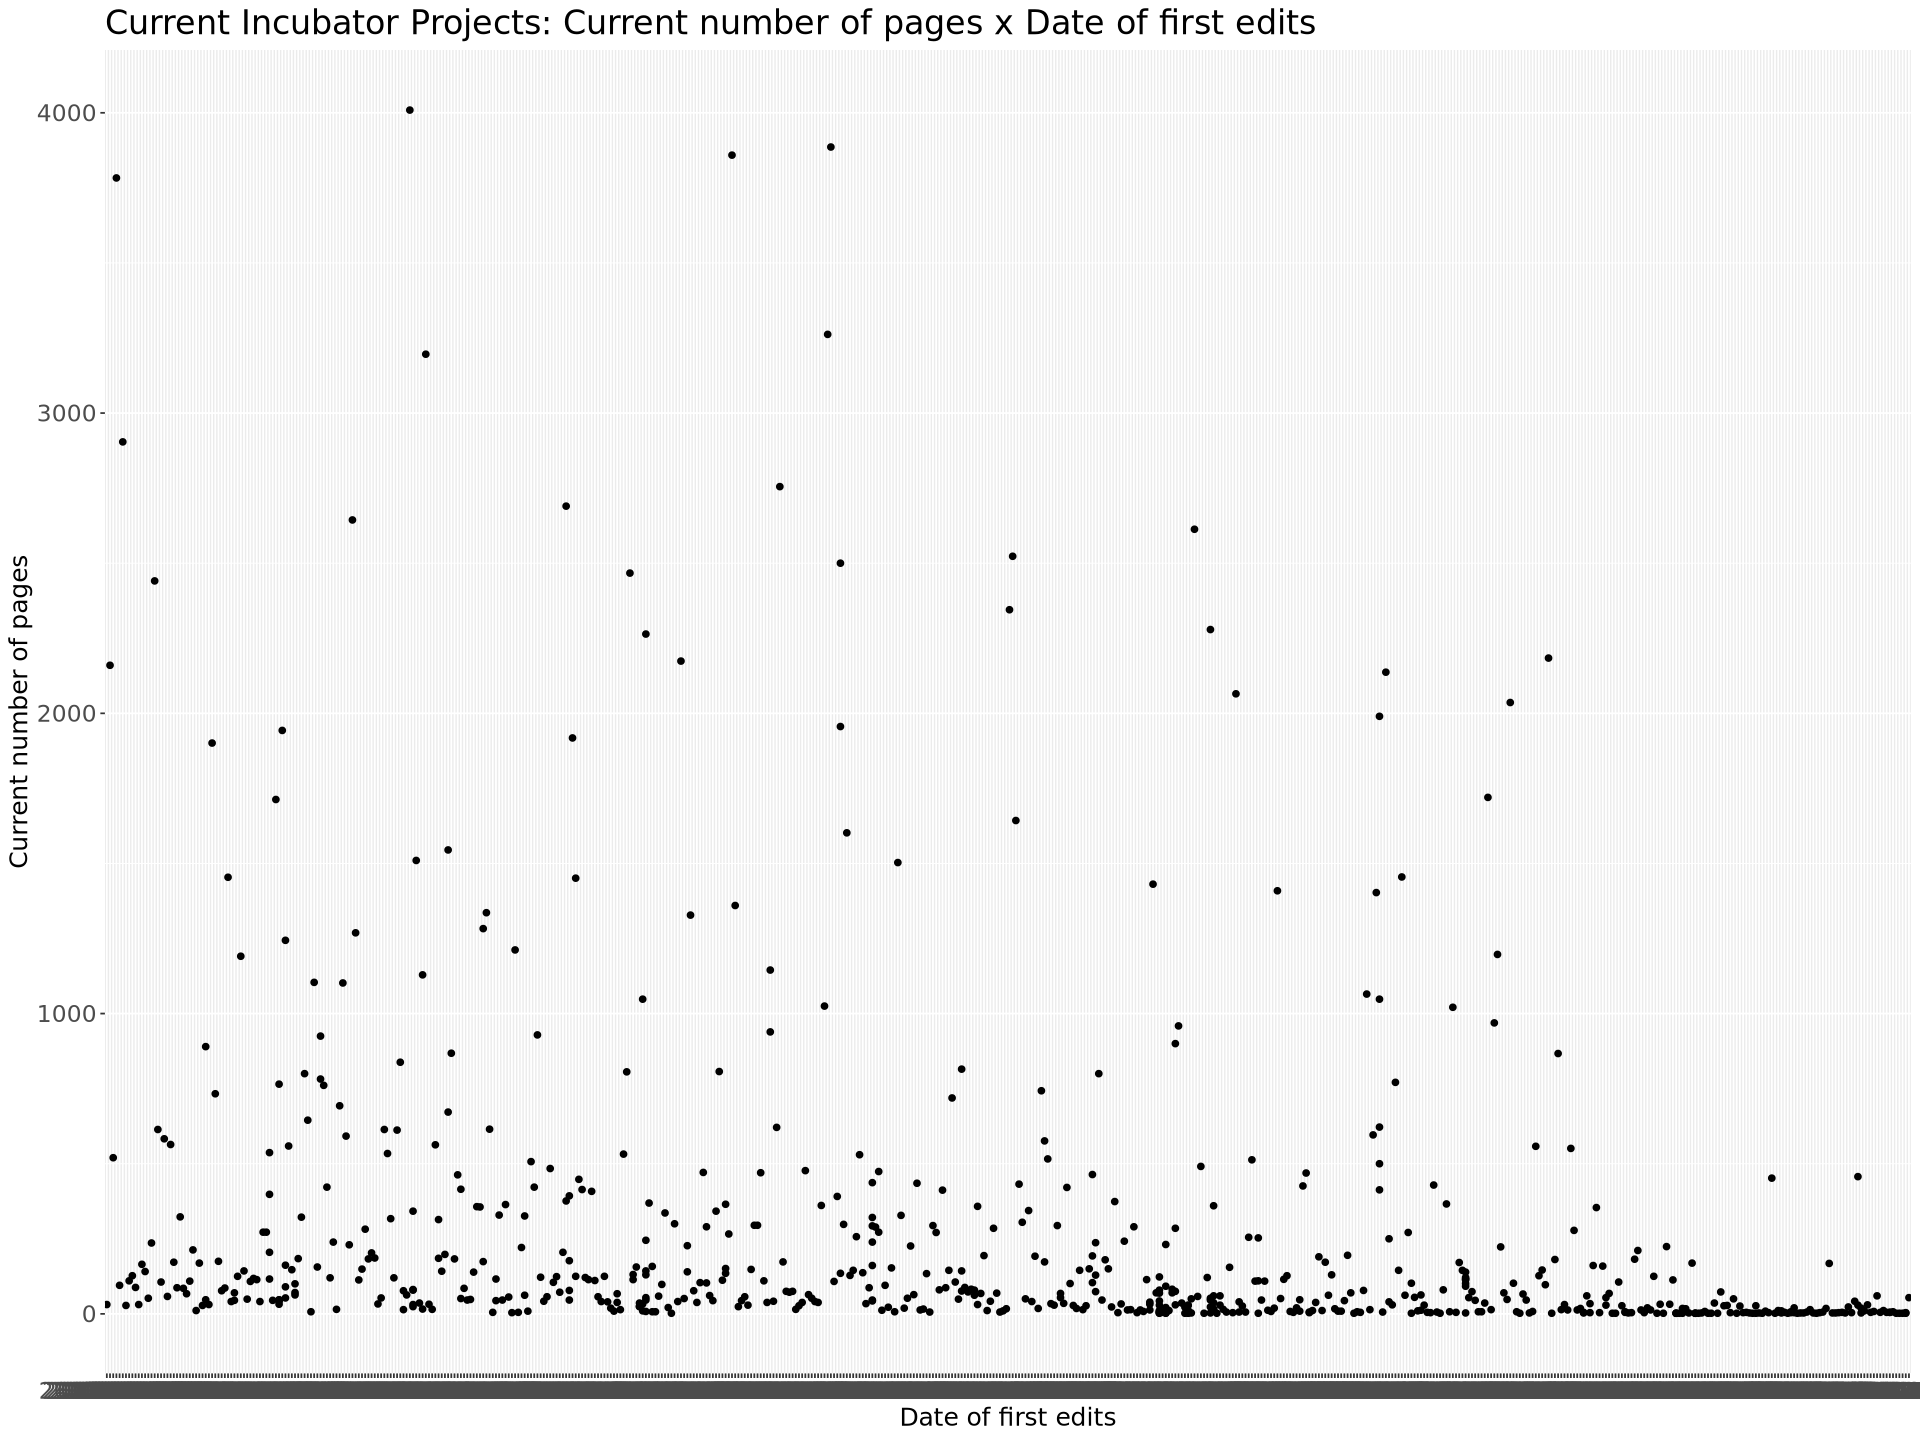

In [94]:
# Join page counts (dfp) with start dates (df)

df_combined <- df %>% 
    select(prefix, first_edit_timestamp, avg_first_edit_5pct) %>%
    full_join(., (dfp %>% select(prefix, pages_count) %>% dplyr::rename("page_count"="pages_count")), by="prefix" ) 

df_combined %>%
    filter(year(first_edit_timestamp) > 2006) %>% #filter out weird ones
    filter(page_count < 5000) %>% #filter out high page counts
    ggplot(aes(x=first_edit_timestamp, y=page_count)) +
    geom_point() +
     theme(legend.position = "left",  strip.text=element_text(size=14), axis.title = element_text(size=15), axis.text=element_text(size=14),
           plot.title = element_text(size=20)) +
    labs(title="Current Incubator Projects: Current number of pages x Date of first edits") +
    xlab("Date of first edits") +
    ylab("Current number of pages")

# Part 4: Visualizing monthly edits

In [96]:
# Define edit_dt
dfe <- dfe %>%
 mutate(edit_dt = paste(year, month, sep="-0")) %>%
 mutate(edit_dt = gsub("-010", "-10", edit_dt)) %>%
 mutate(edit_dt = gsub("-011", "-11", edit_dt)) %>%
 mutate(edit_dt = gsub("-012", "-12", edit_dt)) %>%
 mutate(edit_dt = paste(edit_dt, "-01", sep="")) %>% # add dummy day 01
 mutate(edit_dt = as.Date(edit_dt))

In [97]:
#QA
head(dfe %>% filter(prefix=="Wb/ace") %>% arrange(edit_dt))
head(dfe %>% filter(prefix=="Wb/blk") %>% arrange(edit_dt)) # should not have bc graduated

wiki_db       prefix year month edits_count language_name canonical_status
1 incubatorwiki Wb/ace 2017  6     1          Achinese      NA              
2 incubatorwiki Wb/ace 2017 12     1          Achinese      NA              
3 incubatorwiki Wb/ace 2020  1     1          Achinese      NA              
4 incubatorwiki Wb/ace 2023  7    38          Achinese      NA              
5 incubatorwiki Wb/ace 2023  8    21          Achinese      NA              
6 incubatorwiki Wb/ace 2024  1     2          Achinese      NA              
  test-host project   substantial active edit_dt   
1 test      Wikibooks NA          Yes    2017-06-01
2 test      Wikibooks NA          Yes    2017-12-01
3 test      Wikibooks NA          Yes    2020-01-01
4 test      Wikibooks NA          Yes    2023-07-01
5 test      Wikibooks NA          Yes    2023-08-01
6 test      Wikibooks NA          Yes    2024-01-01

wiki_db prefix year month edits_count language_name canonical_status
     test-host project substantial active edit_dt

In [99]:
head(dfe)

wiki_db       prefix year month edits_count language_name canonical_status
1 incubatorwiki Wy/wuu 2014  1    341         Wu            NA              
2 incubatorwiki Wp/ryu 2022  8    278         Okinawan      NA              
3 incubatorwiki Wp/rkt 2023 12    811         Rangpuri      NA              
4 incubatorwiki Wn/hu  2009 11    219         Hungarian     closed          
5 incubatorwiki Wb/mni 2023  8    329         Manipuri      NA              
6 incubatorwiki Wp/kiu 2011  5    160         Kirmanjki     NA              
  test-host     project    substantial active edit_dt   
1 test          Wikivoyage Yes         NA     2014-01-01
2 test          Wikipedia  Yes         Yes    2022-08-01
3 test          Wikipedia  Yes         Yes    2023-12-01
4 test (closed) Wikinews   Yes         Yes    2009-11-01
5 test          Wikibooks  Yes         Yes    2023-08-01
6 test          Wikipedia  Yes         NA     2011-05-01

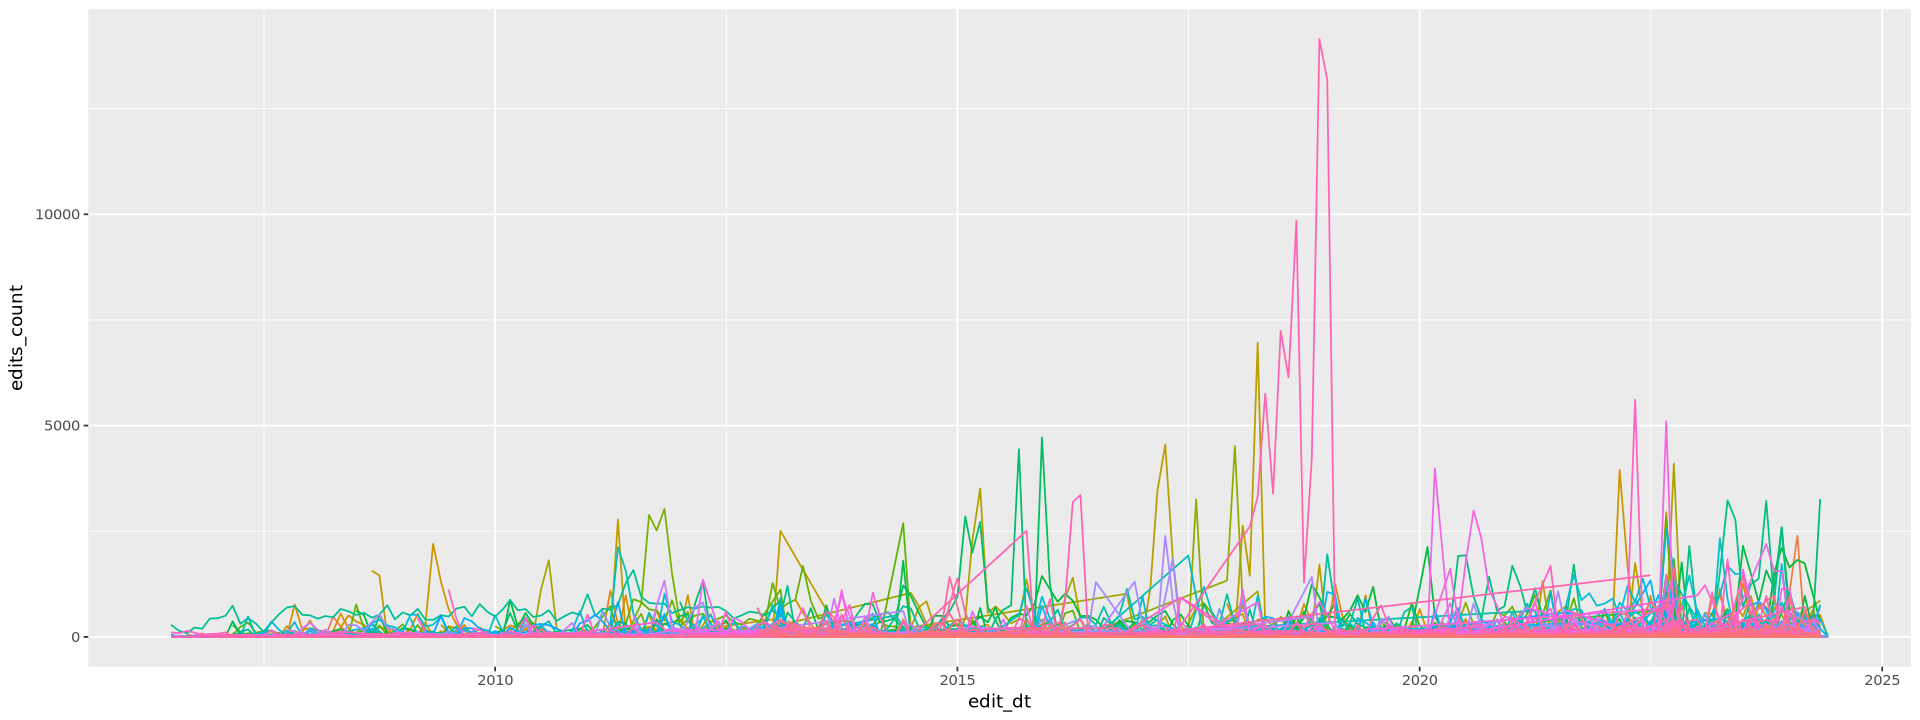

In [100]:
# All project edits, over time - line plot
options(repr.plot.width=16, repr.plot.height=6)
dfe %>%
  filter(edit_dt > "2006-06-01") %>%
  ggplot(aes(x=edit_dt, y=edits_count, color=prefix, group=prefix)) +
  geom_line() +
  theme(legend.position="none")

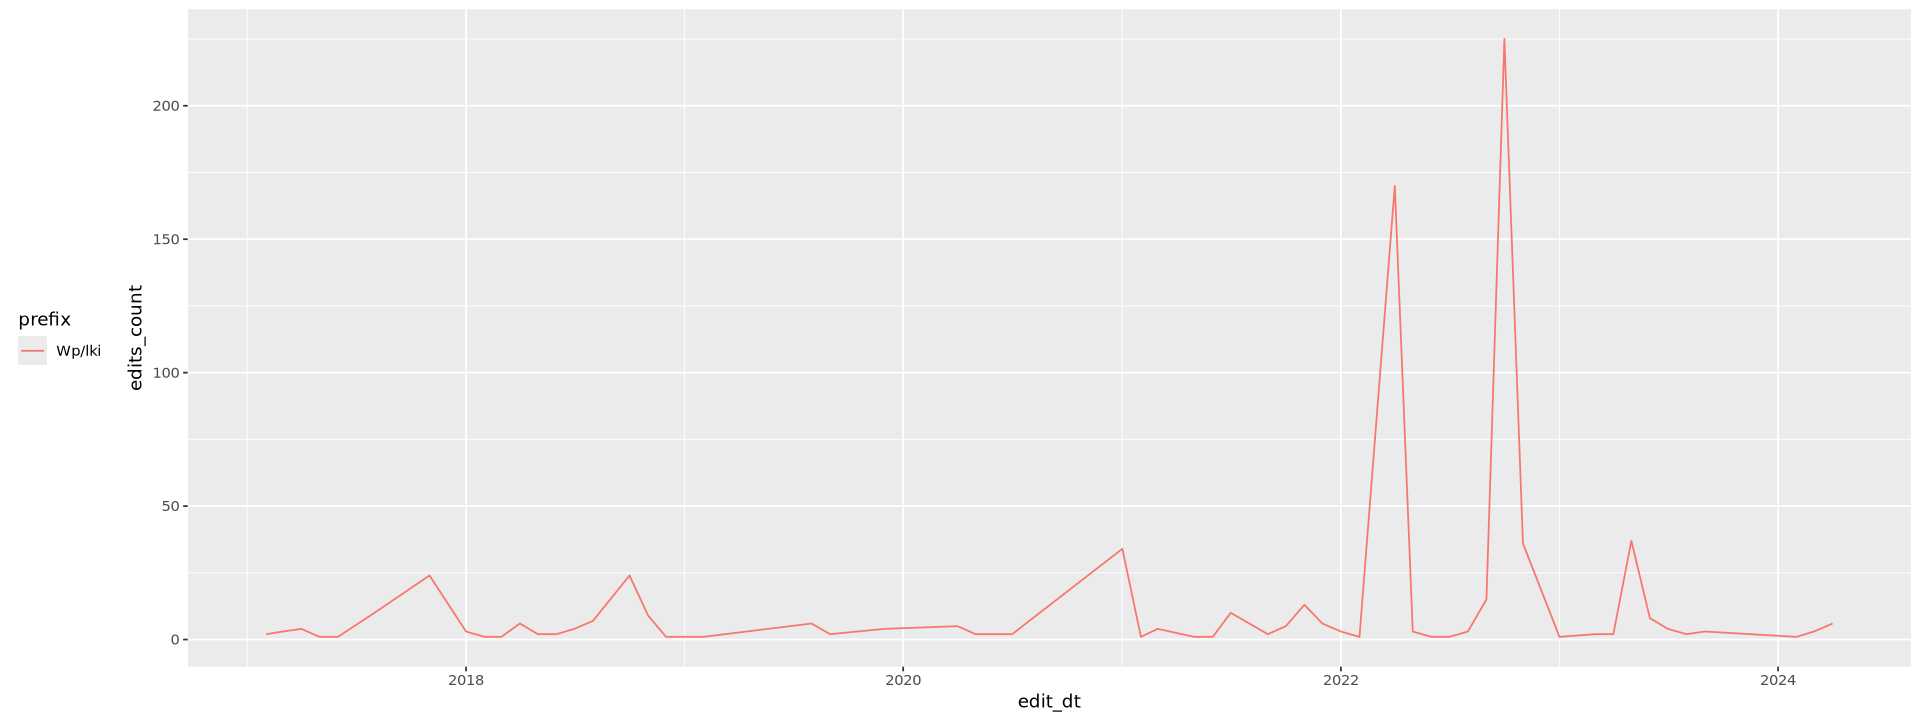

In [101]:
# All project edits, over time (2023 only) - line plot
options(repr.plot.width=16, repr.plot.height=6)
dfe %>%
  filter(grepl("Wp/lki", prefix)) %>%
  filter(year(edit_dt)>"2016") %>%
  ggplot(aes(x=edit_dt, y=edits_count, color=prefix)) +
  geom_line() +
  theme(legend.position="left")

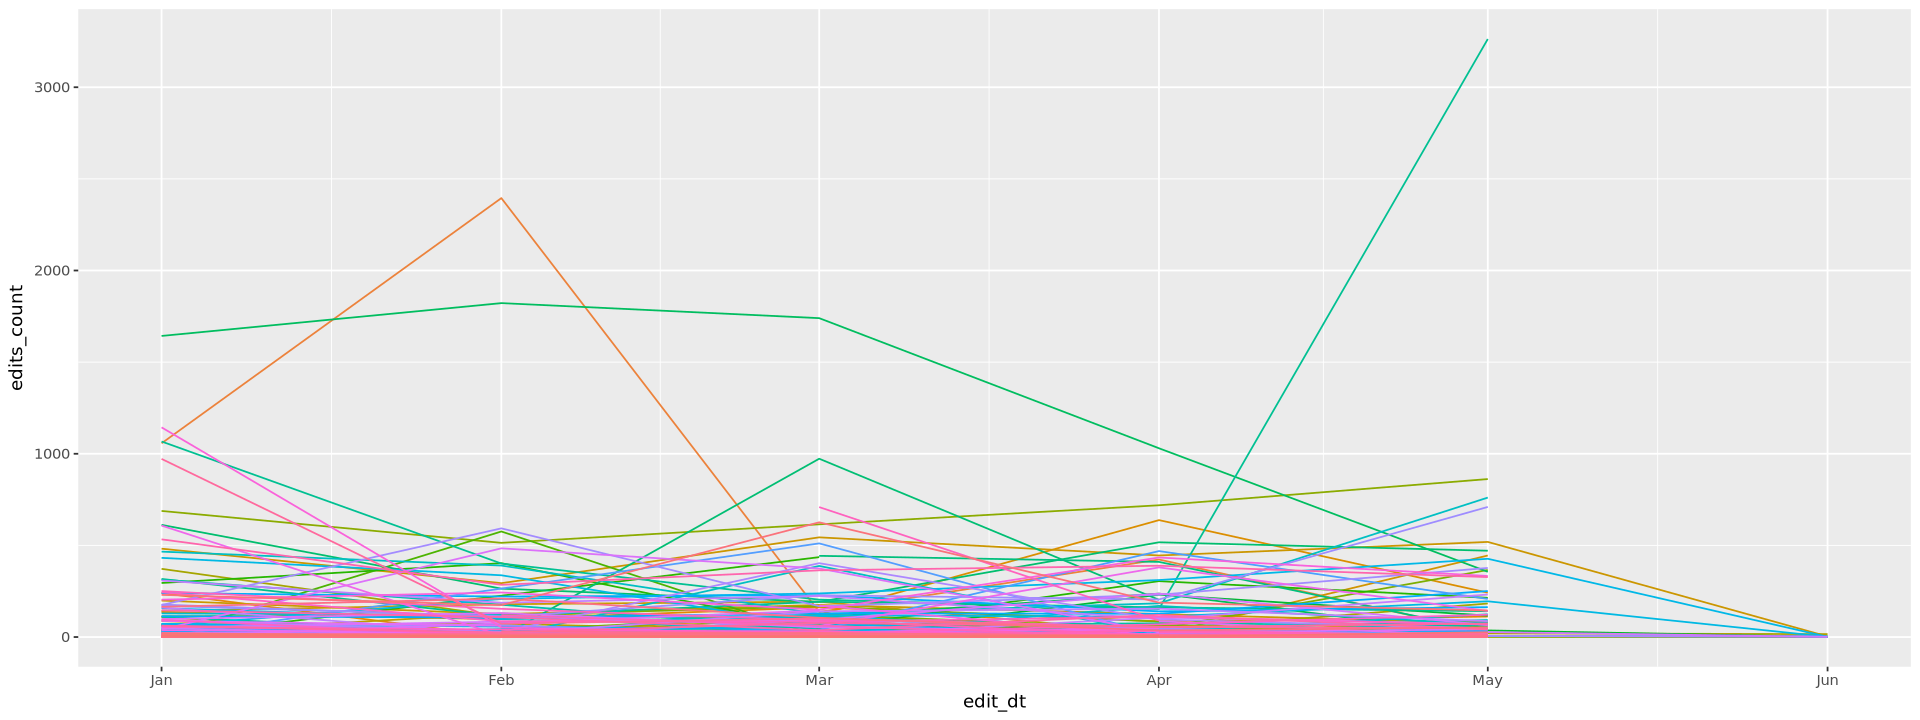

In [102]:
# All project edits, over time (2024 only) - line plot
options(repr.plot.width=16, repr.plot.height=6)
dfe %>%
  filter(year(edit_dt)=="2024") %>%
  ggplot(aes(x=edit_dt, y=edits_count, color=prefix)) +
  geom_line() +
  theme(legend.position="none")

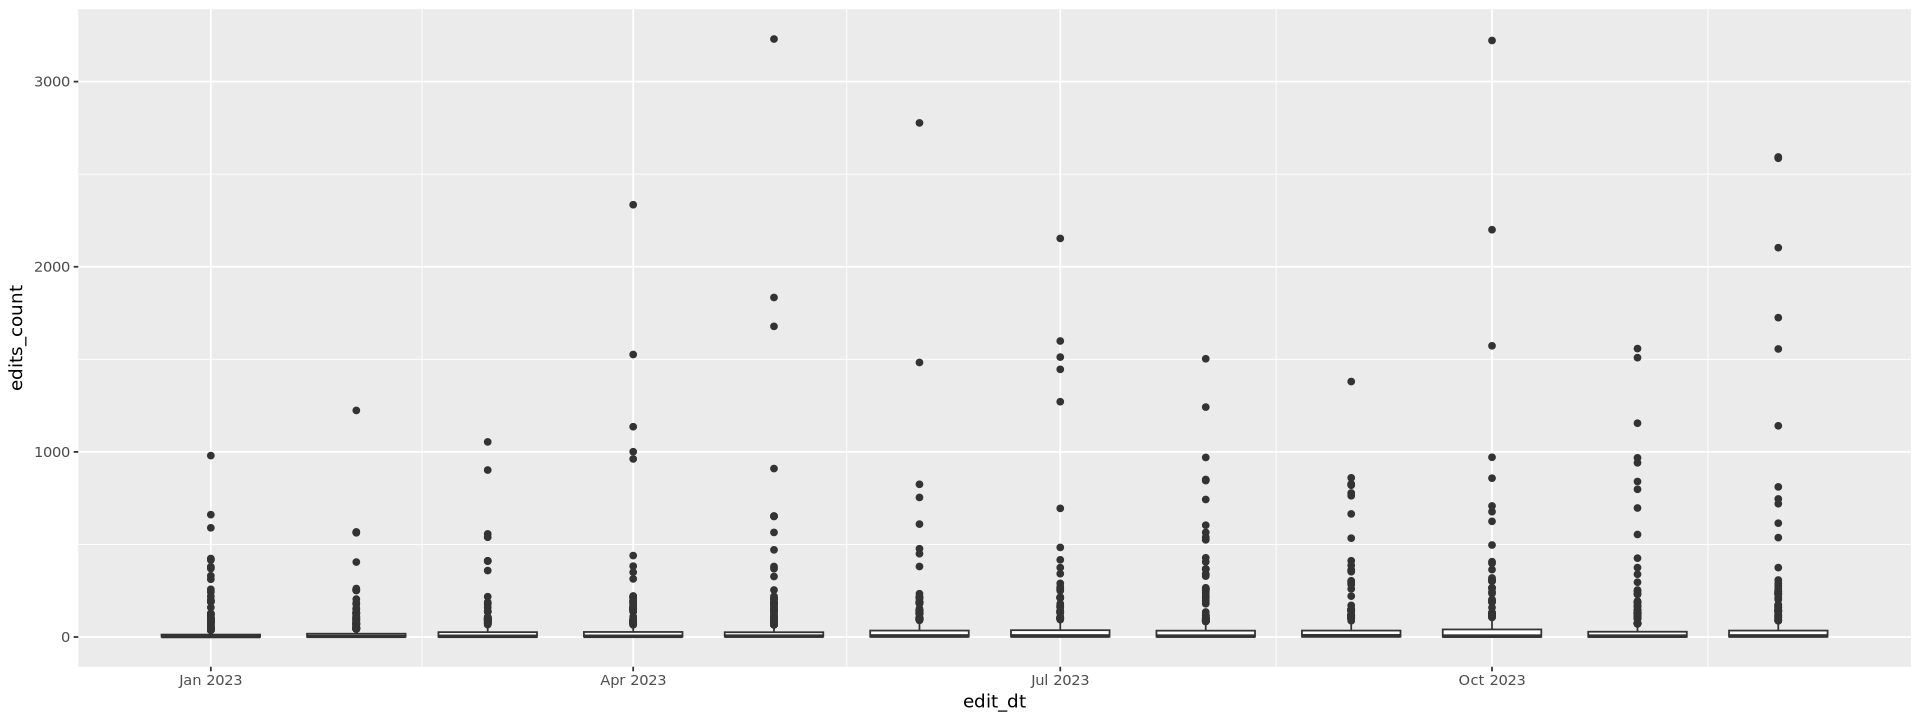

In [104]:
# All project edits, over time (2023 only) - boxplot
options(repr.plot.width=16, repr.plot.height=6)
dfe %>% 
  filter(year(edit_dt)=="2023") %>%
  ggplot(aes(x=edit_dt, y=edits_count, group=month(edit_dt))) +
  geom_boxplot() 

## Look at average monthly edits in 2023

ACTIVE test projects only

In [106]:
# filter for 2023
dfe_2023 <- dfe %>% 
  filter(year(edit_dt)=="2023") 

# widen df
dfe_2023 <- dfe_2023 %>%
  select(-c(year, month)) %>%
  spread(key="edit_dt", value="edits_count") 

# make date columns numeric
dfe_2023 <- dfe_2023 %>% 
  mutate_if(is.double, as.integer)

# make NAs into 0s in the "2023-.." columns
dfe_2023[, 5:16][is.na(dfe_2023[, 5:16])] <- 0

head(dfe_2023)

wiki_db       prefix language_name   canonical_status test-host     project  
1 incubatorwiki Wb/ace Achinese        NA               test          Wikibooks
2 incubatorwiki Wb/ady Adyghe          NA               test          Wikibooks
3 incubatorwiki Wb/arz Egyptian Arabic NA               test          Wikibooks
4 incubatorwiki Wb/as  Assamese        closed           test (closed) Wikibooks
5 incubatorwiki Wb/ban Balinese        NA               test          Wikibooks
6 incubatorwiki Wb/bgc Haryanvi        NA               test          Wikibooks
  substantial active 2023-01-01 2023-02-01 2023-03-01 2023-04-01 2023-05-01
1 0           Yes    0          0          0          0          0         
2 0           Yes    0          0          2          0          0         
3 0           Yes    0          0          0          0          0         
4 Yes         Yes    0          1          0          2          0         
5 0           Yes    0          0          0          0          0         
6 0           Yes    0          0          0          0          0         
  2023-06-01 2023-07-01 2023-08-01 2023-09-01 2023-10-01 2023-11-01 2023-12-01
1 0          38         21         NA         NA         NA         NA        
2 0           0          0          1         NA          1          3        
3 0           1          0         NA         NA         NA         NA        
4 0          35          0         NA          1         NA         NA        
5 0           0          0         NA         NA         NA          5        
6 0           0          3         NA         NA         NA         NA

In [107]:
# calculate and round means
dfe_2023 <- dfe_2023 %>% 
    mutate(mean = round(rowMeans(as.matrix(.[grep('2023', names(.))]), na.rm = TRUE), 1))

# calculate and round medians
dfe_2023 <- dfe_2023 %>% 
    mutate(median = round(rowMedians(as.matrix(.[grep('2023', names(.))]), na.rm = TRUE), 1))

# remove monthly columns
dfe_2023 <- dfe_2023 %>%
  select(wiki_db, prefix, mean, median)

# preview
head(dfe_2023 %>% arrange(desc(mean)))
tail(dfe_2023 %>% arrange(desc(mean)))

wiki_db       prefix mean   median
1 incubatorwiki Wp/mos 1540.9 1311.0
2 incubatorwiki Wp/knc  868.9  635.0
3 incubatorwiki Wp/syl  784.3  710.0
4 incubatorwiki Wy/id   610.2  595.0
5 incubatorwiki Wt/mad  486.5    0.0
6 incubatorwiki Wp/rki  458.2  211.5

wiki_db       prefix mean median
590 incubatorwiki Wt/khw 0.1  0     
591 incubatorwiki Wt/mhr 0.1  0     
592 incubatorwiki Wt/oaa 0.1  0     
593 incubatorwiki Wt/sc  0.1  0     
594 incubatorwiki Wt/szl 0.1  0     
595 incubatorwiki Wy/fj  0.1  0

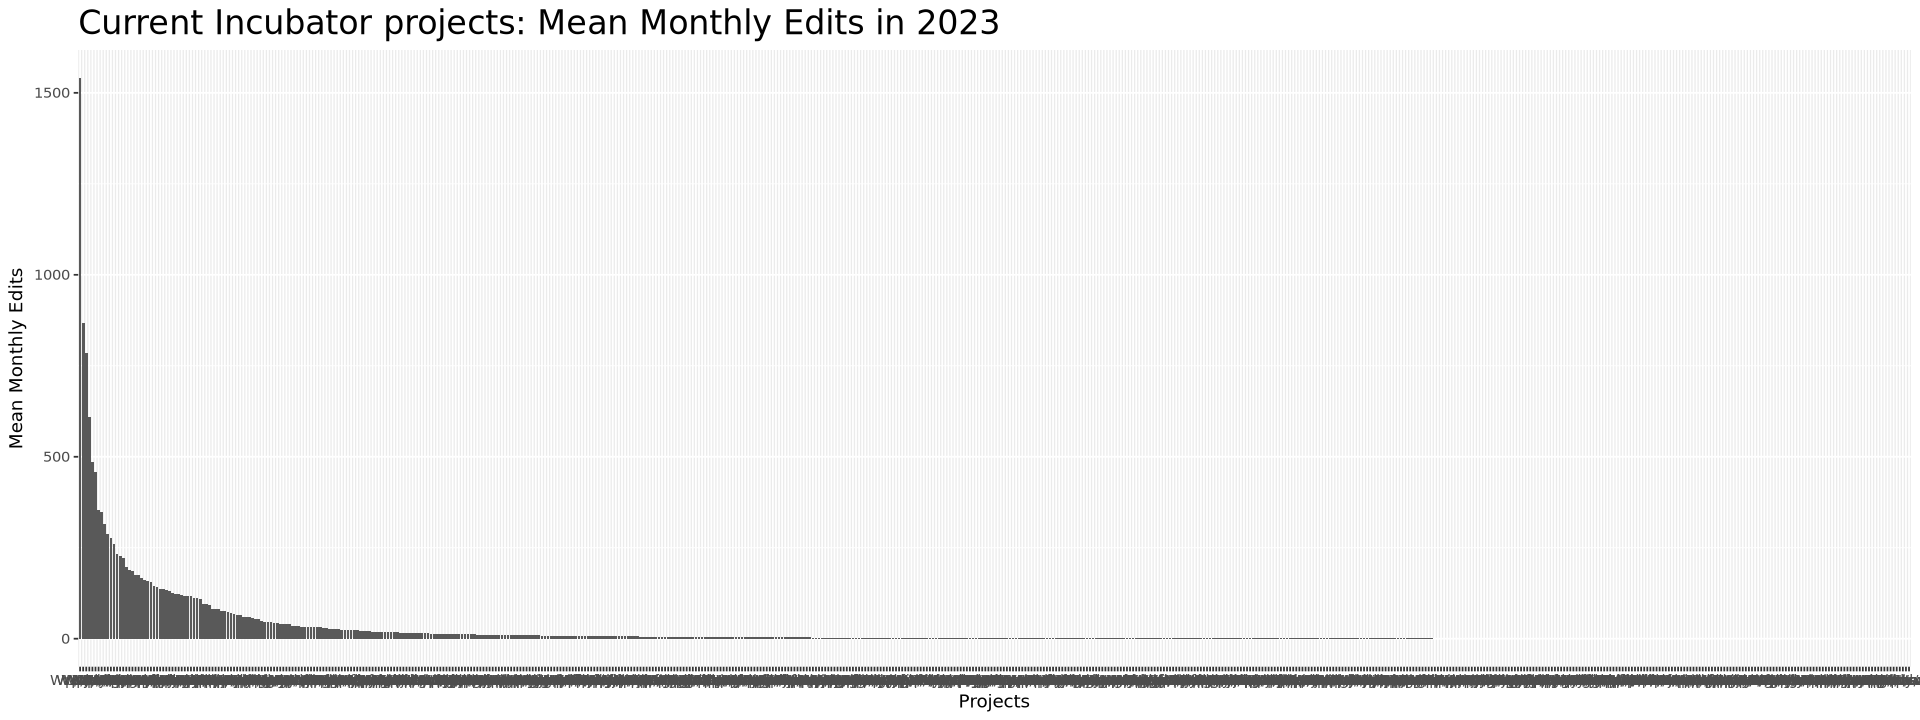

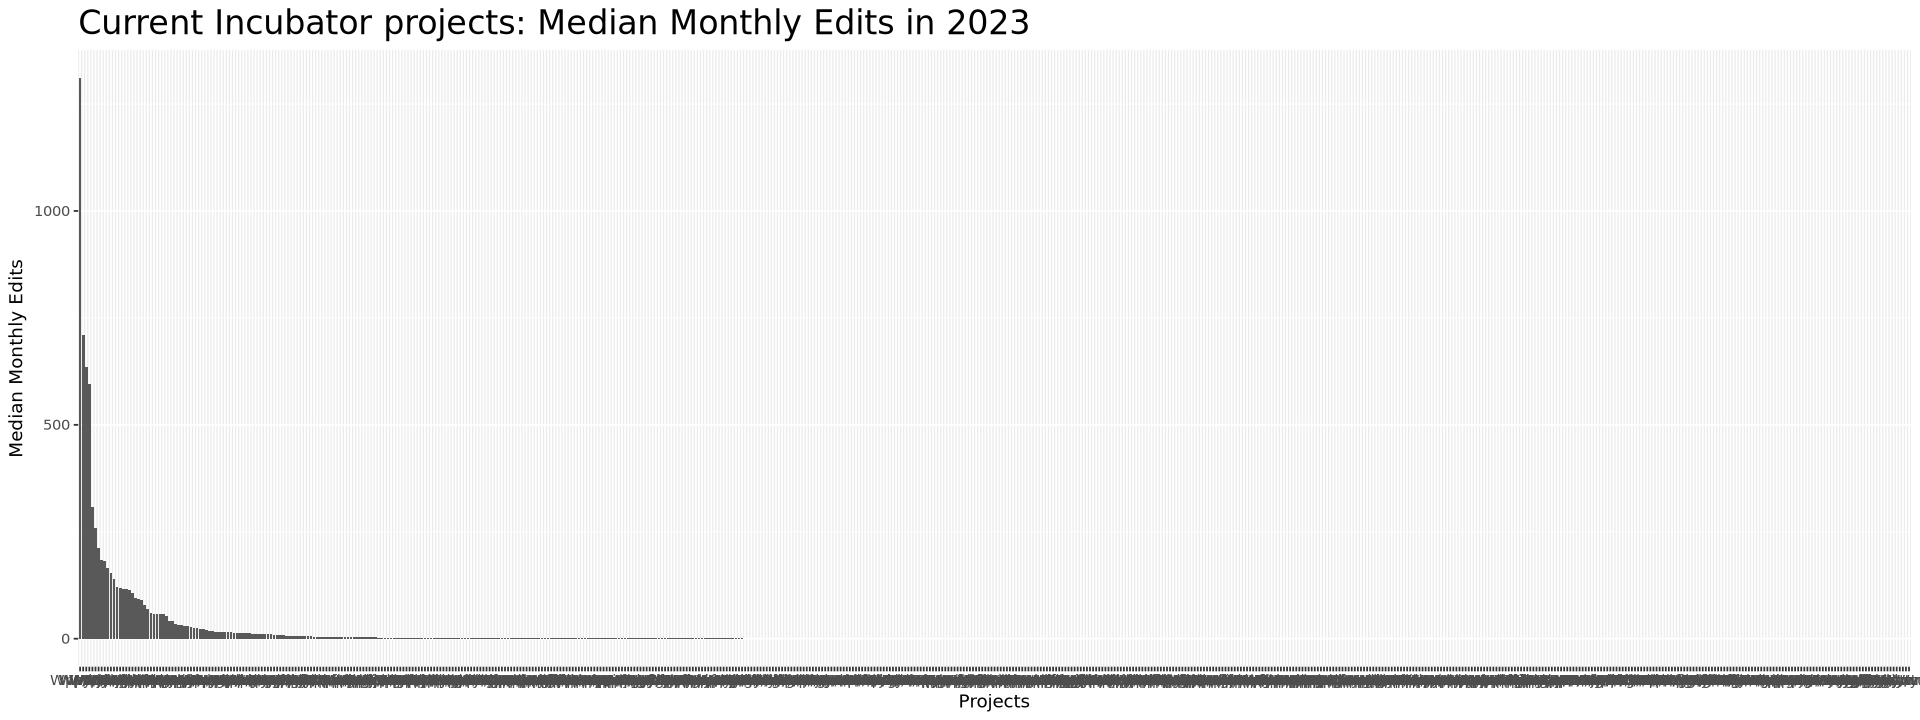

In [108]:
# Plot: Range of means
options(repr.plot.width=16, repr.plot.height=6)
dfe_2023 %>%
 ggplot(aes(x=reorder(prefix,-mean), y=mean)) +
 geom_bar(stat="identity") + xlab("Projects") +
 theme(plot.title=element_text(size=20)) +
 ylab("Mean Monthly Edits") +
 labs(title="Current Incubator projects: Mean Monthly Edits in 2023")

# Plot: Range of medians
options(repr.plot.width=16, repr.plot.height=6)
dfe_2023 %>%
 ggplot(aes(x=reorder(prefix,-median), y=median)) +
 geom_bar(stat="identity") + xlab("Projects") +
 theme(plot.title=element_text(size=20)) +
 ylab("Median Monthly Edits") +
 labs(title="Current Incubator projects: Median Monthly Edits in 2023")

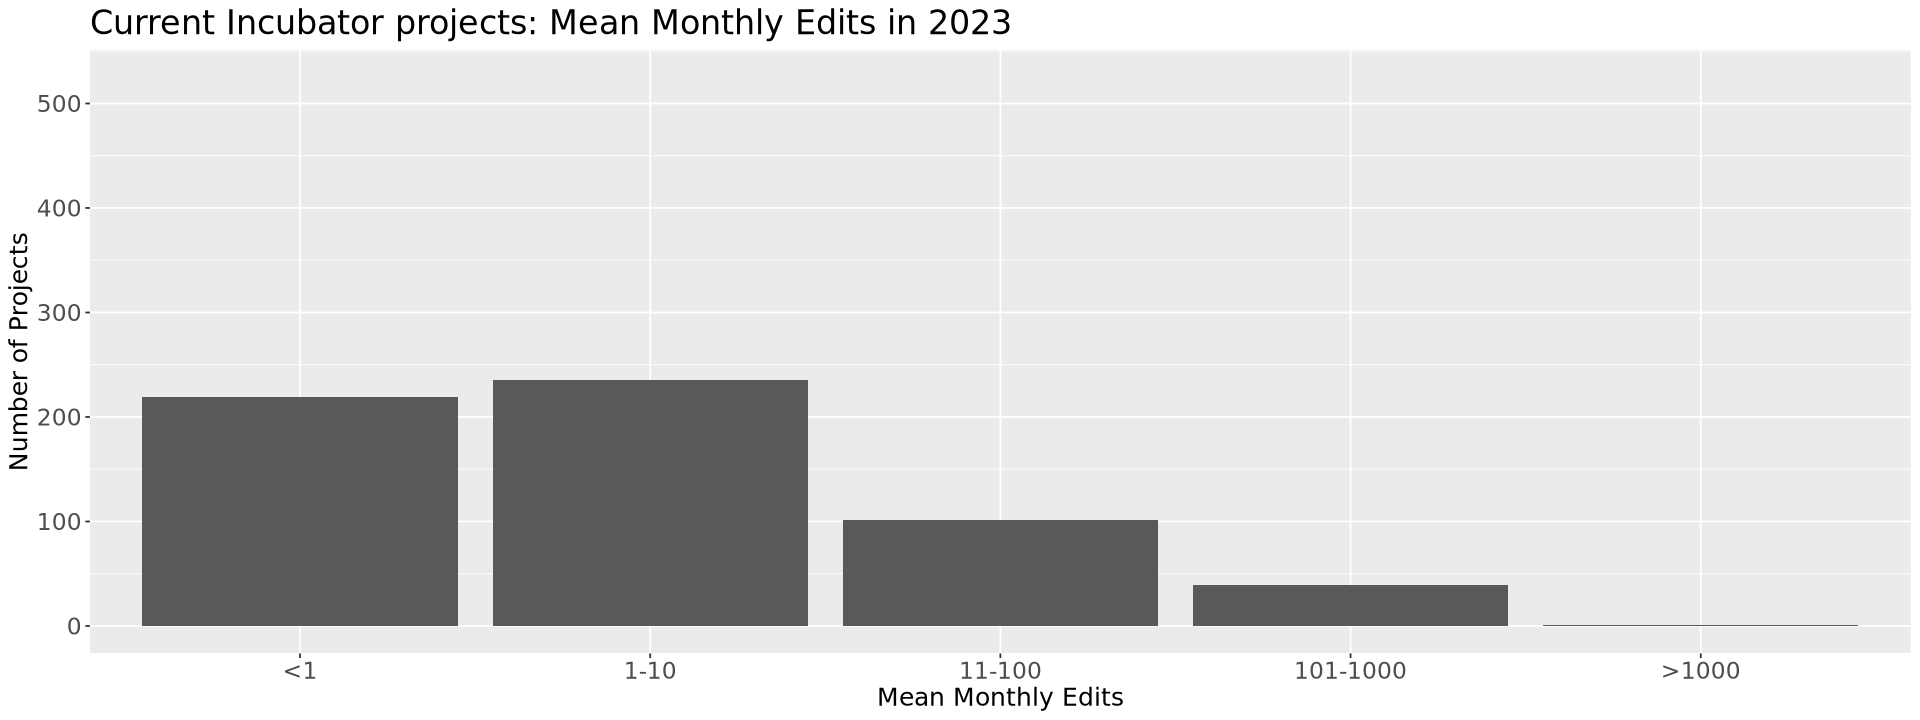

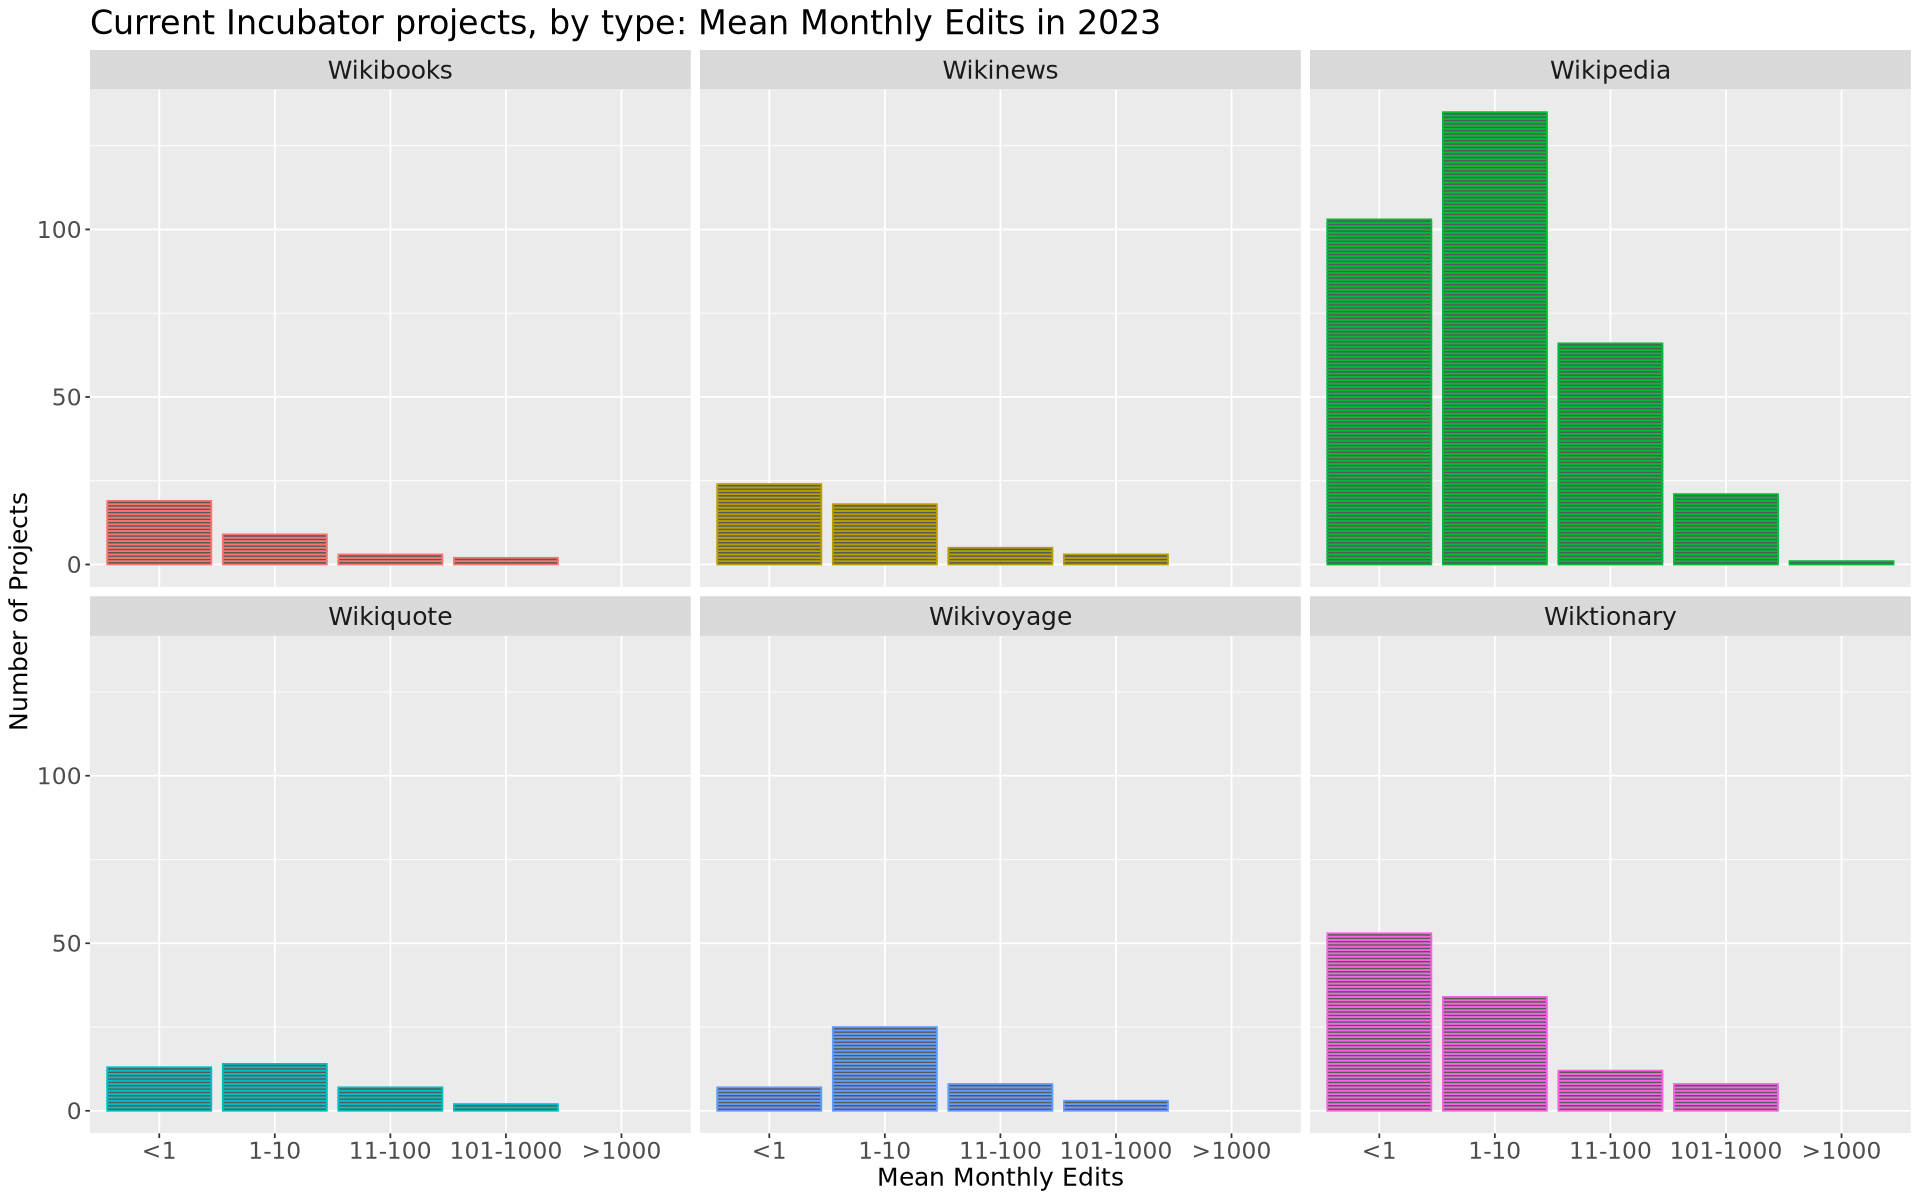

In [109]:
# MEAN BUCKETS
dfe_2023$mean_bucket <- NA
dfe_2023$mean_bucket[dfe_2023$mean<1] <- "<1"
dfe_2023$mean_bucket[dfe_2023$mean>=1 & dfe_2023$mean<11] <- "1-10"
dfe_2023$mean_bucket[dfe_2023$mean>10 & dfe_2023$mean<101] <- "11-100"
dfe_2023$mean_bucket[dfe_2023$mean>100 & dfe_2023$mean<1001] <- "101-1000"
dfe_2023$mean_bucket[dfe_2023$mean>1000] <- ">1000"

#factor
dfe_2023$mean_bucket <-  factor(dfe_2023$mean_bucket, levels = c("<1", "1-10", "11-100", "101-1000", ">1000"))

# dummy count for plotting
dfe_2023$count <- 1

# preview
# head(dfe_2023)

# Plot: Range of mean buckets
options(repr.plot.width=16, repr.plot.height=6)
dfe_2023 %>%
 ggplot(aes(x=reorder(mean_bucket,-count), y=count)) +
 geom_bar(stat="identity") + xlab("Mean Monthly Edits") +
 theme(plot.title=element_text(size=20), 
       axis.text=element_text(size=14),
       axis.title=element_text(size=15)) +
 ylab("Number of Projects") +
 labs(title="Current Incubator projects: Mean Monthly Edits in 2023") +
 ylim(0,525)


# prep for project type
dfe_2023$project_type <- NA
dfe_2023$project_type[grepl("Wp/", dfe_2023$prefix)] <- "Wikipedia"
dfe_2023$project_type[grepl("Wb/", dfe_2023$prefix)] <- "Wikibooks"
dfe_2023$project_type[grepl("Wn/", dfe_2023$prefix)] <- "Wikinews"
dfe_2023$project_type[grepl("Wq/", dfe_2023$prefix)] <- "Wikiquote"
dfe_2023$project_type[grepl("Wt/", dfe_2023$prefix)] <- "Wiktionary"
dfe_2023$project_type[grepl("Wv/", dfe_2023$prefix)] <- "Wikiversity"
dfe_2023$project_type[grepl("Wy/", dfe_2023$prefix)] <- "Wikivoyage"


# Plot: Range of mean buckets, by project type
options(repr.plot.width=16, repr.plot.height=10)
dfe_2023 %>%
 ggplot(aes(x=reorder(mean_bucket,-count), y=count, color=project_type)) +
 geom_bar(stat="identity") + xlab("Mean Monthly Edits") +
 theme(plot.title=element_text(size=20), 
       axis.text=element_text(size=14),
       axis.title=element_text(size=15),
       strip.text=element_text(size=15),
       legend.position="none") +
 ylab("Number of Projects") +
 labs(title="Current Incubator projects, by type: Mean Monthly Edits in 2023") +
 facet_wrap(.~project_type, ncol=3) 

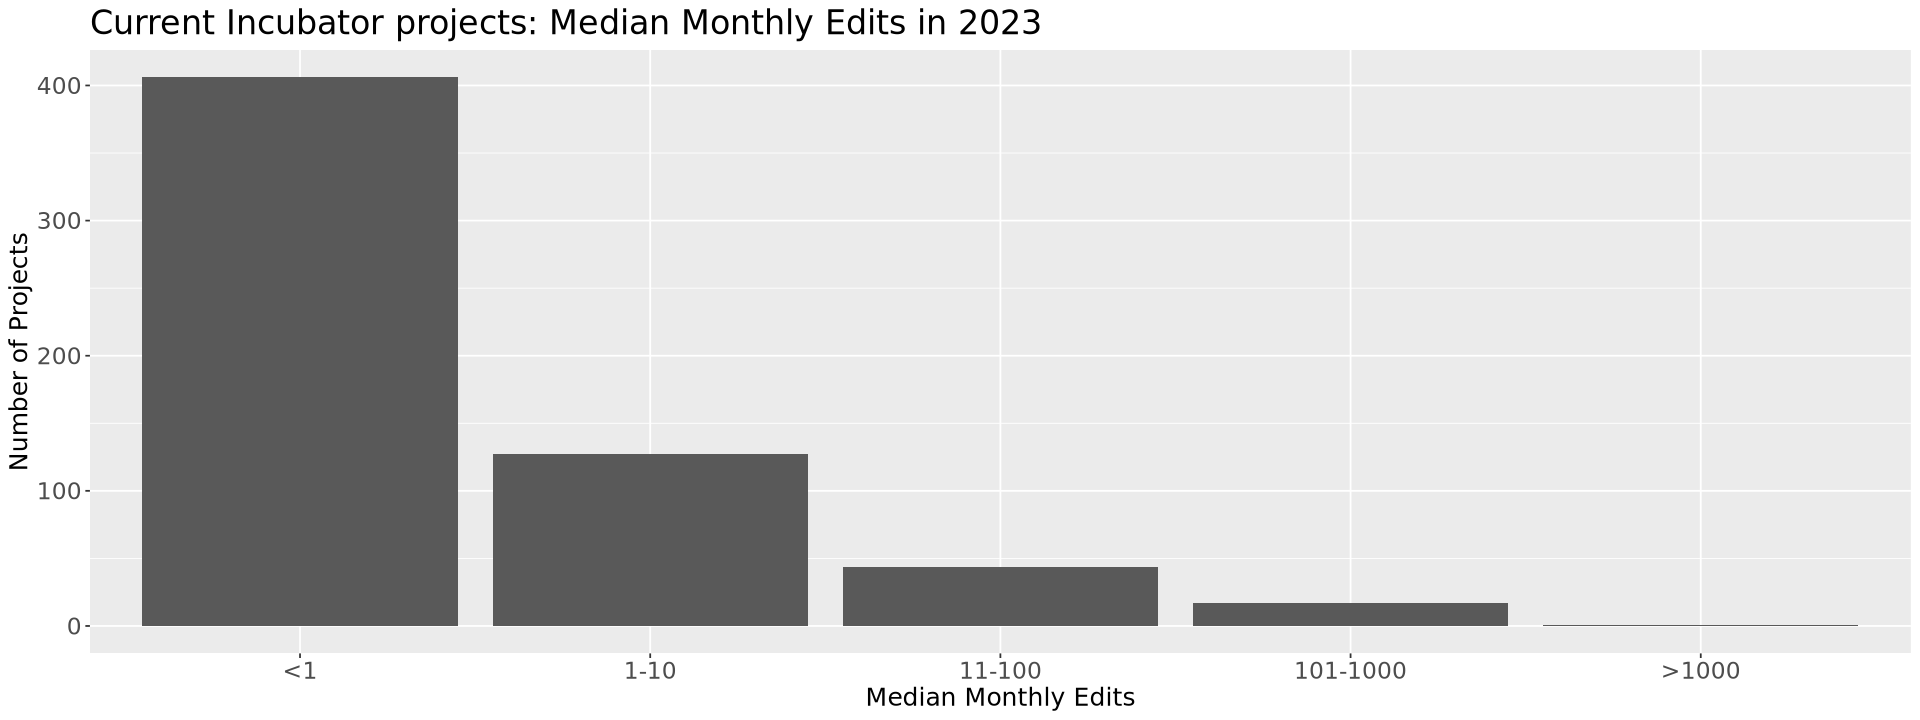

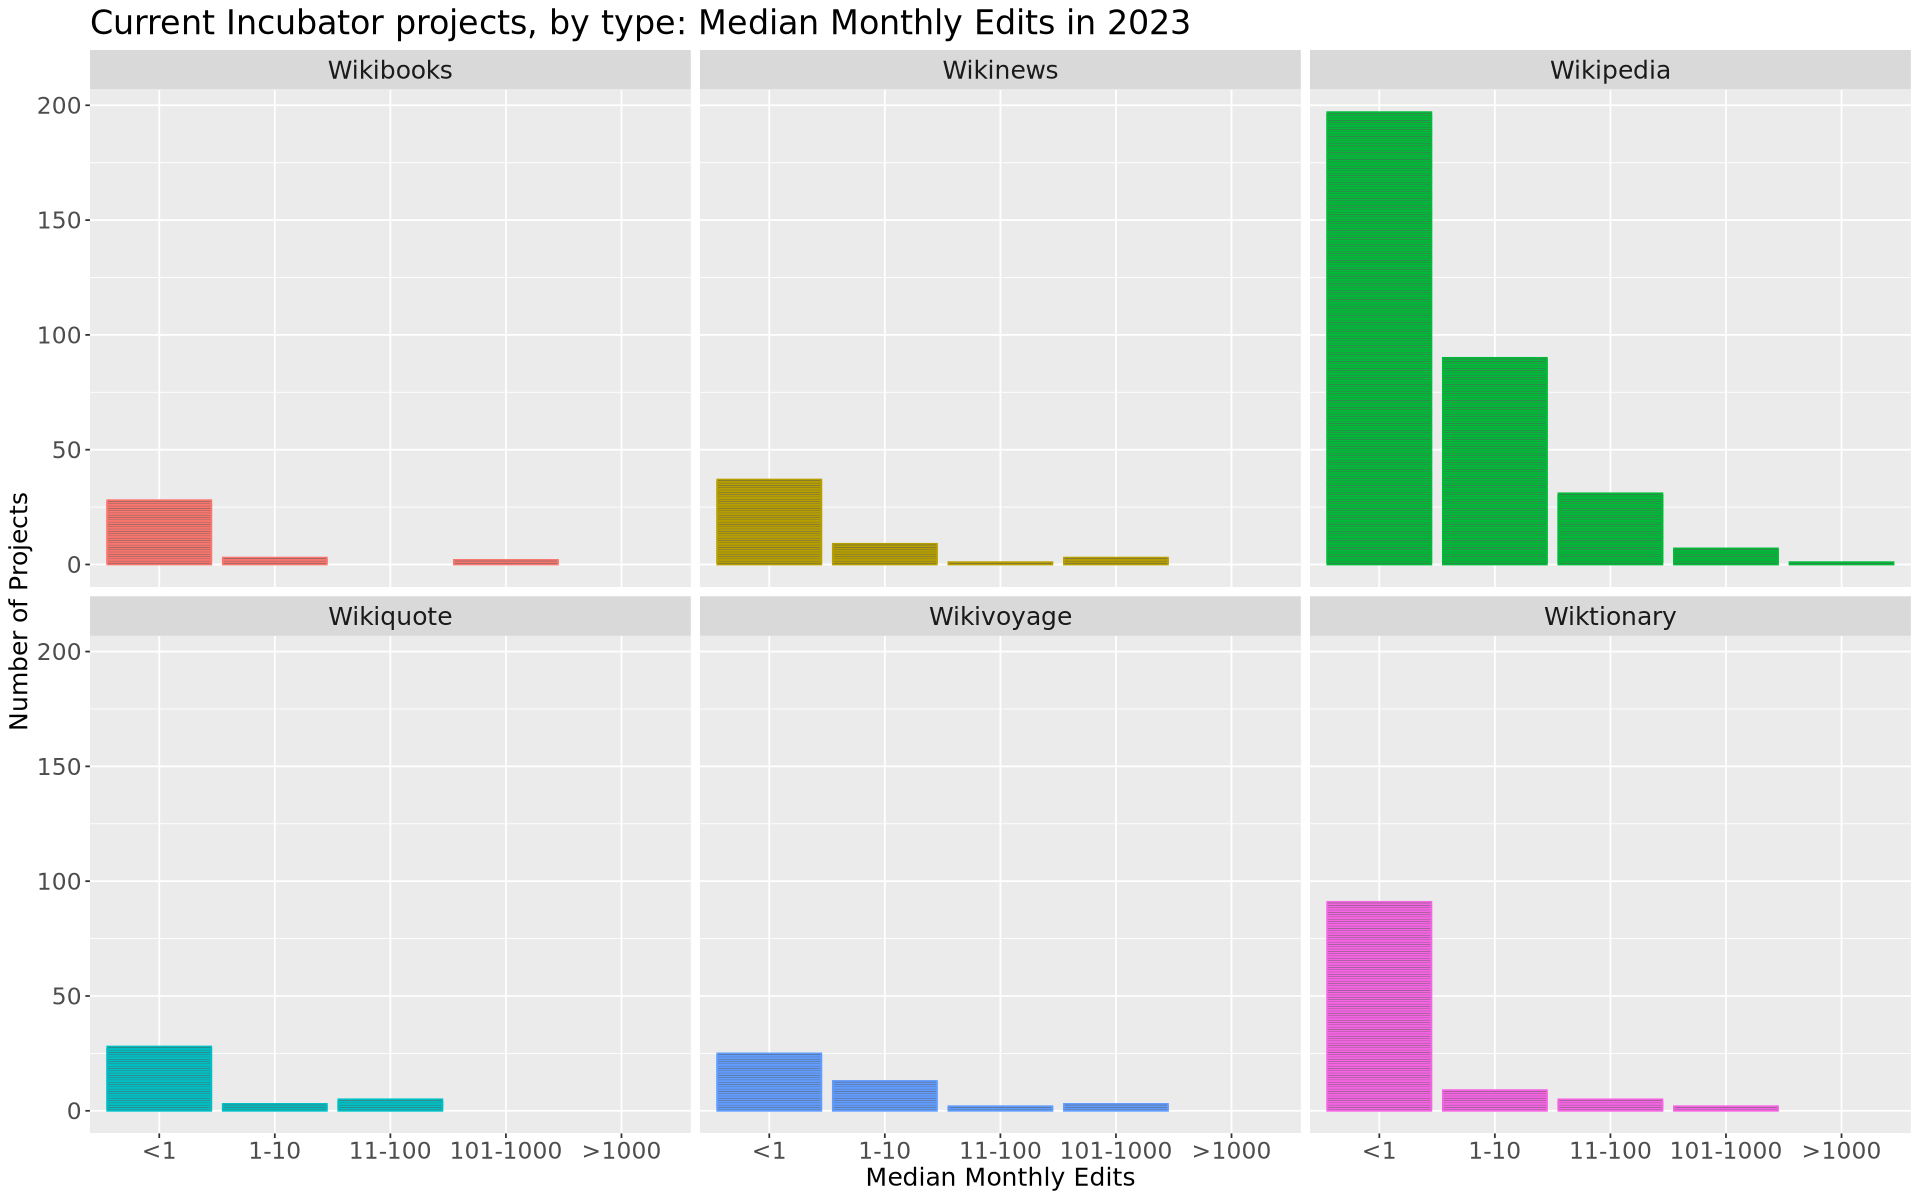

In [110]:
# MEDIAN BUCKETS
dfe_2023$median_bucket <- NA
dfe_2023$median_bucket[dfe_2023$median<1] <- "<1"
dfe_2023$median_bucket[dfe_2023$median>=1 & dfe_2023$median<11] <- "1-10"
dfe_2023$median_bucket[dfe_2023$median>10 & dfe_2023$median<101] <- "11-100"
dfe_2023$median_bucket[dfe_2023$median>100 & dfe_2023$median<1001] <- "101-1000"
dfe_2023$median_bucket[dfe_2023$median>1000] <- ">1000"

#factor
dfe_2023$median_bucket <-  factor(dfe_2023$median_bucket, levels = c("<1", "1-10", "11-100", "101-1000", ">1000"))

# dummy count for plotting
dfe_2023$count <- 1

# preview
# head(dfe_2023)

# Plot: Range of median buckets
options(repr.plot.width=16, repr.plot.height=6)
dfe_2023 %>%
 ggplot(aes(x=reorder(median_bucket,-count), y=count)) +
 geom_bar(stat="identity") + xlab("Median Monthly Edits") +
 theme(plot.title=element_text(size=20), 
       axis.text=element_text(size=14),
       axis.title=element_text(size=15)) +
 ylab("Number of Projects") +
 labs(title="Current Incubator projects: Median Monthly Edits in 2023") 


# prep for project type
dfe_2023$project_type <- NA
dfe_2023$project_type[grepl("Wp/", dfe_2023$prefix)] <- "Wikipedia"
dfe_2023$project_type[grepl("Wb/", dfe_2023$prefix)] <- "Wikibooks"
dfe_2023$project_type[grepl("Wn/", dfe_2023$prefix)] <- "Wikinews"
dfe_2023$project_type[grepl("Wq/", dfe_2023$prefix)] <- "Wikiquote"
dfe_2023$project_type[grepl("Wt/", dfe_2023$prefix)] <- "Wiktionary"
dfe_2023$project_type[grepl("Wv/", dfe_2023$prefix)] <- "Wikiversity"
dfe_2023$project_type[grepl("Wy/", dfe_2023$prefix)] <- "Wikivoyage"


# Plot: Range of median buckets, by project type
options(repr.plot.width=16, repr.plot.height=10)
dfe_2023 %>%
 ggplot(aes(x=reorder(median_bucket,-count), y=count, color=project_type)) +
 geom_bar(stat="identity") + xlab("Median Monthly Edits") +
 theme(plot.title=element_text(size=20), 
       axis.text=element_text(size=14),
       axis.title=element_text(size=15),
       strip.text=element_text(size=15),
       legend.position="none") +
 ylab("Number of Projects") +
 labs(title="Current Incubator projects, by type: Median Monthly Edits in 2023") +
 facet_wrap(.~project_type, ncol=3)

In [111]:
# Show data plotted above as a table (i.e., page number buckets project, but as %s)
dfe_2023$weight=1
as.data.frame(moe_crosstab(df=dfe_2023, x=project_type, y=median_bucket, weight=weight)) %>%
 mutate(pct=paste0(round(pct,1), "%")) %>%
 select(project_type, median_bucket, pct) %>%
 spread(key=median_bucket, value=pct)

project_type <1    1-10  11-100 101-1000 >1000
1 Wikibooks    84.8% 9.1%  NA     6.1%     NA   
2 Wikinews     74%   18%   2%     6%       NA   
3 Wikipedia    60.4% 27.6% 9.5%   2.1%     0.3% 
4 Wikiquote    77.8% 8.3%  13.9%  NA       NA   
5 Wikivoyage   58.1% 30.2% 4.7%   7%       NA   
6 Wiktionary   85%   8.4%  4.7%   1.9%     NA

wiki_db       prefix mean median mean_bucket count project_type median_bucket
1 incubatorwiki Wb/ace 7.4  0      1-10        1     Wikibooks    <1           
2 incubatorwiki Wb/ady 0.6  0      <1          1     Wikibooks    <1           
3 incubatorwiki Wb/arz 0.1  0      <1          1     Wikibooks    <1           
4 incubatorwiki Wb/as  4.3  0      1-10        1     Wikibooks    <1           
5 incubatorwiki Wb/ban 0.6  0      <1          1     Wikibooks    <1           
6 incubatorwiki Wb/bgc 0.4  0      <1          1     Wikibooks    <1           
  weight first_edit_year
1 1      2017           
2 1      2017           
3 1      2019           
4 1      2009           
5 1      2023           
6 1      2023

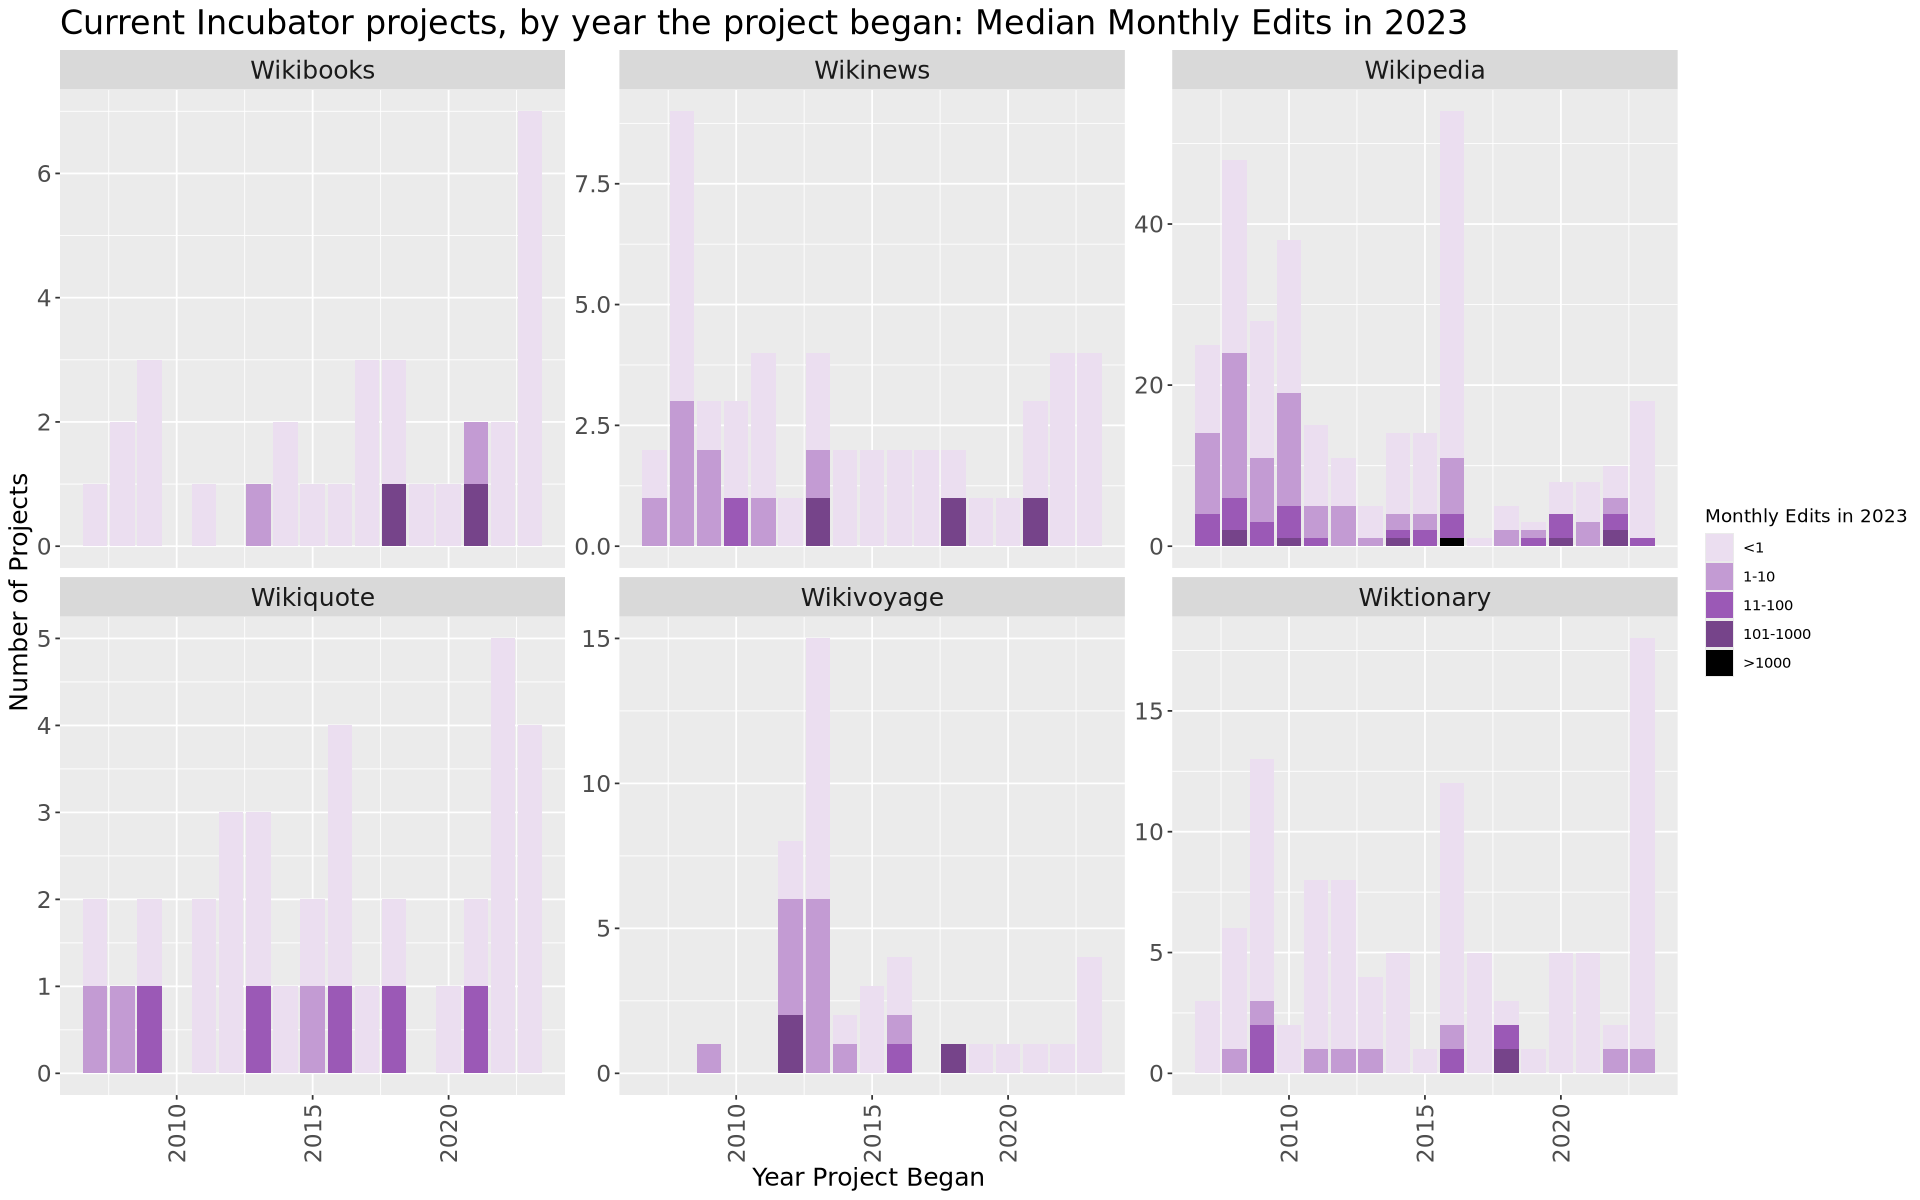

In [112]:
## Show data plotted above but faceted by the year the project started
q2 <- dfe_2023 %>% 
 left_join(., (df %>% select(prefix, first_edit_timestamp)), by="prefix") %>%
 mutate(first_edit_year = lubridate::year(first_edit_timestamp)) %>% 
 select(-first_edit_timestamp) %>%
 mutate(weight=1)

head(q2)

moe_crosstab_3way(df=q2, x=project_type, y=median_bucket, z=first_edit_year, weight=weight) %>%
 mutate(pct_x_n = pct/100*n) %>%
 filter(first_edit_year > 2006) %>% # filter out weird cases
 ggplot(aes(x=first_edit_year, y=pct_x_n, fill=median_bucket)) +
 geom_bar(stat="identity") + xlab("Year Project Began") +
 theme(plot.title=element_text(size=20), 
       axis.text.y=element_text(size=14),
       axis.title=element_text(size=15),
       axis.text.x = element_text(angle = 90, size=14, vjust = 0.5, hjust=1),
       strip.text=element_text(size=15)) +
 ylab("Number of Projects") +
 labs(title="Current Incubator projects, by year the project began: Median Monthly Edits in 2023") +
 facet_wrap(.~project_type, ncol=3, scales="free_y") +
 scale_fill_manual(values = c("#EBDEF0",  "#C39BD3",  "#9B59B6",  "#76448A", "black")) +
 guides(fill=guide_legend(title="Monthly Edits in 2023"))